In [66]:
import os
from matplotlib import pyplot as plt
import numpy as np
import sys
from scipy.special import jn
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import scipy.special as sps

from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer
from functools import partial

#=== 5PN AAK imports ================

from few.trajectory.inspiral import EMRIInspiral
#from few.waveform import Pn5AAKWaveform # we don't need waveform generation
#from few.utils.utility import get_fundamental_frequencies


sys.path.append(os.path.abspath('../KerrOrbitalAngleConversion/build/lib.macosx-11.0-arm64-cpython-313/'))

# Constants
G = 6.674080e-11 #Gravitational constant in SI
c = 299792458. #speed of light in SI
MSUN = 1.98848e30 #Mass of sun in SI
YRSID = 31558149.763545603 #seconds in one year 

# Functions

In [ ]:
def Radial_Coordinate(p, e, Phi_r):
    return p/(1 + e * np.cos(Phi_r))

def Polar_Coordinate(x, Phi_theta):
    return np.arccos(np.sqrt(1-x**2)*np.cos(Phi_theta))
    #return np.arccos(x*np.cos(Phi_theta))

def sph2cart(r,theta,phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x,y,z

def bl2kep2(t,a,p,e,x,Phi_r, Phi_theta, Phi_phi):
    rr = Radial_Coordinate(p, e, Phi_r)
    tt = Polar_Coordinate(x, Phi_theta)
    return [t, *sph2cart(rr,tt,Phi_phi)]

def bl2kep(t, a, p, e, x, Phi_r, Phi_theta, Phi_phi):
    # Using https://arxiv.org/abs/2411.04955
    bl_angles=[]
    for i in np.arange(1,len(t)): #skipping the first, it always gives nan...
        AA = kac.pyBoyerLindquistPhasesToDarwinPhases(a,p[i],e[i],x[i],Phi_r[i],Phi_theta[i],Phi_phi[i])
        if np.any(np.isnan(AA)):
            print("ALERT! Proper BoyerLidquist2Darwin failed, using less accurate version!!!")
            return bl2kep2(t,a,p,e,x,Phi_r, Phi_theta, Phi_phi)
        else:
            bl_angles.append(AA)
    psi_from_AA,chi_from_AA,phi_from_AA = np.array(bl_angles).T
    tt = t[1:len(bl_angles)+1]
    pp = p[1:len(bl_angles)+1]
    ee = e[1:len(bl_angles)+1]
    xx = x[1:len(bl_angles)+1]
    r_from_AA = Radial_Coordinate(pp, ee, psi_from_AA)
    theta_from_AA = Polar_Coordinate(xx, chi_from_AA)
    x_coord_from_AA, y_coord_from_AA, z_coord_from_AA = sph2cart(r_from_AA ,theta_from_AA, phi_from_AA)
    trajectory = [tt,x_coord_from_AA,y_coord_from_AA,z_coord_from_AA]
    return trajectory

def Keplerian_p_from_f(M, mu, f_orb_0, e0):
    return c**2*(1-e0**2)/(2*np.pi*f_orb_0*G*(M+mu)*MSUN)**(2/3)

def intersect_trajectory_with_disk(trajectory, disk_center, disk_normal, disk_radius):
    intersections = []
    disk_normal = np.array(disk_normal) / np.linalg.norm(disk_normal)  # Ensure unit normal
    disk_center = np.array(disk_center)
    trajectory = np.array(trajectory).T
    for i in range(len(trajectory) - 1):
        p1, p2 = np.array(trajectory[i]), np.array(trajectory[i + 1])
        segment = p2 - p1
        denom = np.dot(segment[1:], disk_normal)
        if np.isclose(denom, 0, atol=1e-8):
            print("Segment is parallel to the disk plane, skipping!") # Should be better about this!!!
            continue  
        t = np.dot(disk_center - p1[1:], disk_normal) / denom
        if 0 <= t <= 1:
            intersection = p1 + t * segment
            if np.linalg.norm(intersection[1:] - disk_center) <= disk_radius:
                intersections.append(intersection.tolist())
    
    return np.array(intersections)

def intersect_trajectory_with_rotating_disk(trajectory, disk_center0, disk_normal0, disk_radius, omega, tol=1e-8, max_iter=50, num_samples=200):
    """
    Finds intersections between a trajectory and a disk that rotates about the z-axis 
    with angular frequency omega.
    
    The disk is defined in its body frame (time zero) by:
      - disk_center0: center (3-vector)
      - disk_normal0: unit normal (3-vector)
      - disk_radius: scalar radius
      
    At time t the disk is rotated in the inertial frame as:
      disk_center(t) = Rz(omega*t) @ disk_center0
      disk_normal(t) = Rz(omega*t) @ disk_normal0
      
    A trajectory point p=(t,x,y,z) lies in the disk plane at time t if, after rotating by -omega*t,
    its spatial part p_body satisfies:
      (p_body - disk_center0) · disk_normal0 = 0.
    
    For non-coplanar segments (i.e. crossing the plane) a bisection routine is used to locate the unique crossing.
    If a segment is (nearly) coplanar, then the entire segment lies in the disk plane, and we search
    for intersections of the segment with the disk’s circular boundary.
    
    Parameters:
      trajectory: list or tuple of 4 array-like objects [t, x, y, z] (each with shape (N,)).
      disk_center0: array-like, initial center of the disk (3-vector).
      disk_normal0: array-like, initial normal of the disk (3-vector; will be normalized).
      disk_radius: scalar, radius of the disk.
      omega: angular frequency of the disk's rotation about the z-axis.
      tol: tolerance for root finding.
      max_iter: maximum iterations for bisection.
      num_samples: number of samples used in the coplanar case.
      
    Returns:
      intersections: np.array of intersection points (each is (t,x,y,z)).
    """
    intersections = []
    disk_normal0 = np.array(disk_normal0, dtype=float)
    disk_normal0 /= np.linalg.norm(disk_normal0)
    disk_center0 = np.array(disk_center0, dtype=float)

    # Expect trajectory to be [t array, x array, y array, z array].
    if len(trajectory) != 4:
        raise ValueError("Trajectory must be a list of 4 arrays: [t, x, y, z].")
    traj = np.column_stack(trajectory)

    # Inline rotation: computes Rz(-omega*tau)*pos for a spatial 3-vector.
    def rotate_z_neg(angle, pos):
        c = np.cos(angle)
        s = np.sin(angle)
        return np.array([c * pos[0] + s * pos[1],
                         -s * pos[0] + c * pos[1],
                         pos[2]])

    # Process each segment.
    for i in range(len(traj) - 1):
        p1 = traj[i]
        p2 = traj[i + 1]
        dt = p2[0] - p1[0]
        if dt == 0:
            continue  # Skip segments with zero time difference

        pos_diff = p2[1:] - p1[1:]
        t_diff = dt

        # f(lam) measures how far the rotated spatial point is from the disk plane.
        def f(lam):
            tau = p1[0] + lam * t_diff
            pos = p1[1:] + lam * pos_diff
            pos_body = rotate_z_neg(omega * tau, pos)
            return np.dot(pos_body - disk_center0, disk_normal0)
        
        f0 = f(0.0)
        f1 = f(1.0)

        # Check if the segment is nearly coplanar with the disk.
        if np.abs(f0) < tol and np.abs(f1) < tol:
            # Define g(lam): distance from disk center (in body frame) minus disk_radius.
            def g(lam):
                tau = p1[0] + lam * t_diff
                pos = p1[1:] + lam * pos_diff
                pos_body = rotate_z_neg(omega * tau, pos)
                return np.linalg.norm(pos_body - disk_center0) - disk_radius

            # Sample g(lam) over the segment.
            lam_vals = np.linspace(0, 1, num_samples)
            g_vals = np.array([g(lam) for lam in lam_vals])

            # Look for sign changes or near-zero values.
            for j in range(len(lam_vals) - 1):
                if np.abs(g_vals[j]) < tol:
                    lam_root = lam_vals[j]
                elif g_vals[j] * g_vals[j+1] < 0:
                    lam_low = lam_vals[j]
                    lam_high = lam_vals[j+1]
                    g_low = g_vals[j]
                    for _ in range(max_iter):
                        lam_mid = (lam_low + lam_high) / 2.0
                        g_mid = g(lam_mid)
                        if np.abs(g_mid) < tol:
                            break
                        if g_low * g_mid < 0:
                            lam_high = lam_mid
                        else:
                            lam_low = lam_mid
                            g_low = g_mid
                    lam_root = (lam_low + lam_high) / 2.0
                else:
                    continue
                tau_sol = p1[0] + lam_root * t_diff
                pos_sol = p1[1:] + lam_root * pos_diff
                intersection = np.hstack(([tau_sol], pos_sol))
                if not any(np.allclose(intersection, x, atol=tol) for x in intersections):
                    intersections.append(intersection)
            continue

        # For non-coplanar segments, check endpoints and then use bisection.
        if np.abs(f0) < tol:
            lam_sol = 0.0
        elif np.abs(f1) < tol:
            lam_sol = 1.0
        elif f0 * f1 > 0:
            continue  # No crossing.
        else:
            lam_low = 0.0
            lam_high = 1.0
            f_low = f0
            lam_sol = None
            for _ in range(max_iter):
                lam_mid = (lam_low + lam_high) / 2.0
                f_mid = f(lam_mid)
                if np.abs(f_mid) < tol:
                    lam_sol = lam_mid
                    break
                if f_low * f_mid < 0:
                    lam_high = lam_mid
                else:
                    lam_low = lam_mid
                    f_low = f_mid
            if lam_sol is None:
                lam_sol = (lam_low + lam_high) / 2.0

        if lam_sol < 0 or lam_sol > 1:
            continue

        tau_sol = p1[0] + lam_sol * t_diff
        pos_sol = p1[1:] + lam_sol * pos_diff
        pos_body = rotate_z_neg(omega * tau_sol, pos_sol)
        if np.linalg.norm(pos_body - disk_center0) <= disk_radius:
            intersection = np.hstack(([tau_sol], pos_sol))
            intersections.append(intersection)

    return np.vstack(intersections) if intersections else np.array([])


def plot_inclined_disk(ax, center, radius, normal, num_points=100, color='red', alpha=0.3):
    """
    Plots a transparent disk in 3D, oriented according to the given normal vector.
    
    Parameters:
      ax        : The 3D axes to plot on.
      center    : Tuple (x, y, z) for the disk center.
      radius    : Radius of the disk.
      normal    : The desired normal vector (as an array-like of 3 numbers).
      num_points: Number of points used to sample the circle.
      color     : Disk color.
      alpha     : Transparency (0 is fully transparent, 1 is opaque).
    """
    # Create a circle in the xy-plane (z = 0)
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z = np.zeros_like(x)
    points = np.vstack((x, y, z))  # shape: (3, num_points)
    
    # Normalize the input normal vector
    normal = np.array(normal, dtype=float)
    normal /= np.linalg.norm(normal)
    
    # The default disk normal is along the z-axis
    z_axis = np.array([0, 0, 1])
    
    # Compute the rotation axis (cross product) and angle (via dot product)
    v = np.cross(z_axis, normal)
    s = np.linalg.norm(v)
    c = np.dot(z_axis, normal)
    # If s is close to zero, the normals are parallel.
    if np.isclose(s, 0):
        if c < 0:
            # 180 degree rotation: flip x and y.
            R = np.array([[-1,  0,  0],
                          [ 0, -1,  0],
                          [ 0,  0,  1]])
        else:
            R = np.eye(3)
    else:
        # Rodrigues' rotation formula components
        vx = np.array([[0, -v[2], v[1]],
                       [v[2], 0, -v[0]],
                       [-v[1], v[0], 0]])
        R = np.eye(3) + vx + np.dot(vx, vx) * ((1 - c) / (s**2))
    
    # Rotate the circle points
    points_rot = R.dot(points)
    
    # Translate points to the specified center
    points_rot[0, :] += center[0]
    points_rot[1, :] += center[1]
    points_rot[2, :] += center[2]
    
    # Create a 3D polygon from the points and add it to the axes
    poly = Poly3DCollection([points_rot.T], color=color, alpha=alpha,edgecolors='none')
    ax.add_collection3d(poly)

def gaussian_peaks(t, crossing_times, width=0.05):
    """
    Generates a sum of Gaussian peaks centered at given crossing times.

    Parameters:
    t : array-like
        Time values for evaluation.
    crossing_times : list or array
        List of times where Gaussians should peak.
    width : float
        Standard deviation of the Gaussians (controls peak width).

    Returns:
    array:
        Sum of Gaussian peaks evaluated at t.
    """
    t = np.asarray(t)
    result = np.zeros_like(t)

    for crossing in crossing_times:
        result += np.exp(-((t - crossing) ** 2) / (2 * width ** 2)) #* np.exp(1j * width * (t - crossing)).real

    return result

def generate_template(x1, x2, dt=20):
    # System Parameters
    M = x1
    m = x2
    f1_measured = 0.0007380463140752472
    e0 = 0.22865665220266215
    a = 0.0
    p0 = Keplerian_p_from_f(M, m, f1_measured, e0)
    iota0 = 0.0
    #iota0 = 0.001
    Y0 = np.cos(iota0)
    Phi_phi0 = 0.
    Phi_theta0 = 1.2
    Phi_r0 = 3.5

    # Extrinsic params
    qS = 0.2
    phiS = 0.2
    qK = 0.8
    phiK = 0.8
    dist = 5.235888314207546
    mich = False
    dt = dt
    T = 0.001

    # Disk Params
    disk_center0 = [0.0, 0.0, 0.0]
    disk_normal0 = [0.0, 2.0, 1.0]
    disk_radius = 100000
    omega = 2*np.pi/(60*60*24*3.5)  # disk rotates about the z-axis at 1 rad/s
    omega = 0

    # set initial parameters (default parameters in FEW AAK Documentation)
    traj = EMRIInspiral(func='SchwarzEccFlux')


    # Make the gravitational wave strain, 3D trajectory, crossings and EM signal
    t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, m, a, p0, e0, Y0,
                                Phi_phi0 = Phi_phi0, Phi_theta0 = Phi_theta0, Phi_r0 = Phi_r0,
                                dt=dt, T=T,upsample=True,fix_t=True)


    trajectory = bl2kep2(t, a, p, e, x, Phi_r, Phi_theta, Phi_phi)

    intersections = intersect_trajectory_with_rotating_disk(trajectory, disk_center0, disk_normal0, disk_radius, omega)

    data = gaussian_peaks(trajectory[0], intersections.T[0], width=10*2)  #NOTE: width is 10*2
    return data

def chi_squared_wrapper(x, data, dt, noise_factor):
    x1, x2 = x[0], x[1]
    template = generate_template(x1, x2, dt)
    return chi_squared(data, template, dt, noise_factor)

def chi_squared(data, template, dt, noise_factor=1):
    return np.sum(data*template - 0.5*template*template)/noise_factor * dt

10.819609027106658
Chi squared is 846.9136612514724
SNR is 41.15613347367491


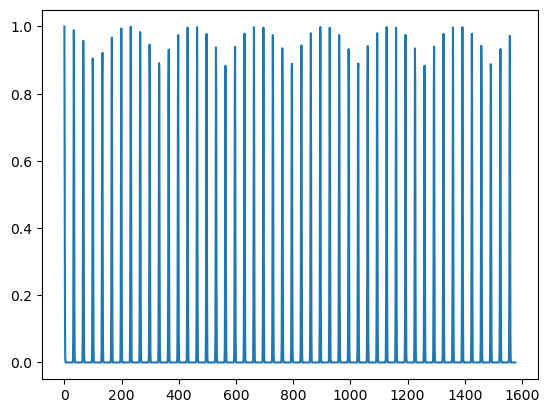

In [72]:

dt = 20
noise_factor = 1.0
data_injection=generate_template(1134944.869275098, 29.489999547765798, dt=dt)
plt.plot(data_injection)
print(f'Chi squared is {chi_squared(data_injection, data_injection, dt, noise_factor=1.0)}')
print(f'SNR is {np.sqrt(2*chi_squared(data_injection, data_injection, dt, noise_factor=1.0))}' )


In [ ]:

prior = ProbDistContainer({
    0: uniform_dist(1133944.869275098, 1135944.869275098),
    1: uniform_dist(24.489999547765798, 34.489999547765798),
})
nwalkers = 20
ndim = 2
sampler = EnsembleSampler(nwalkers, ndim, partial(chi_squared_wrapper, data=data_injection, dt=dt, noise_factor=noise_factor), prior)


start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)

end_point = sampler.run_mcmc(start_state, 1000, progress=True)

10.818039360498009
10.825950392086895
10.81510773607688
10.821676397184248
10.819904384968586
10.819099661965144
10.817731406970736
10.813795900540331
10.825533257212975
10.813476952399341
10.813907102953111
10.820058944757488
10.813737634759157
10.818949434088271
10.823712922430417
10.816019271268624
10.818438001560775
10.820002836726719
10.820596949607124
10.821763141187734


  0%|          | 0/1000 [00:00<?, ?it/s]

10.822134503228728
10.818682000273327
10.822724014771612
10.814970225037431
10.818379846262111
10.814682533802545
10.815082820008335
10.819062127761221
10.814519233015744
10.818452513394178
10.820533611012292
10.82131187780388


  0%|          | 1/1000 [00:00<12:36,  1.32it/s]

10.822885758679085
10.824685147700912
10.818586563704402
10.820417302501527
10.825983142276883
10.817958170390668
10.818443669698867
10.82257115976558


  0%|          | 2/1000 [00:01<10:22,  1.60it/s]

10.814492636917816
10.818472267367191
10.819056786498061
10.82083863153477
10.822983404641807
10.81462722157914
10.817265477794296
10.818344408357992
10.818950395575111
10.821442504794375
10.815355005037055
10.817737648838795
10.818422285741603
10.818554279061669
10.824301531448413
10.823839476291429


  0%|          | 3/1000 [00:01<10:54,  1.52it/s]

10.823435051029891
10.816256366200669
10.824226746266874
10.81832652871548
10.821445890389244
10.820617919288711
10.821901051559543
10.818414311183789
10.825552129943757
10.813490192301249
10.818564148609603


  0%|          | 4/1000 [00:02<11:14,  1.48it/s]

10.818802374785589
10.819996796286945
10.816354110414954
10.817622584945466
10.81970769208114
10.817855484584795
10.820014669291394
10.81982969101272
10.825012235995839
10.821501716763079
10.815872337240371
10.82582137794515
10.825277242102487
10.82003587871816
10.822148513970019
10.821152744525541


  0%|          | 5/1000 [00:03<11:54,  1.39it/s]

10.814476844551871
10.825891687505298
10.818033677391632
10.820019129372069
10.818496740998023
10.81989981993864
10.820894655933161
10.823338113158878
10.814341508656808
10.824361059100596
10.820015211598836
10.821360042939924


  1%|          | 6/1000 [00:04<11:27,  1.45it/s]

10.815224501660508
10.824859986540243
10.814317804364785
10.82042782103081
10.816813151243846
10.818726601815984
10.82266137160047
10.820913351047018
10.818007491277307
10.819210042450404
10.814672969942576
10.822879181179255


  1%|          | 7/1000 [00:04<11:43,  1.41it/s]

10.820110094897165
10.819549356733878
10.817848550180953
10.81943643116145
10.817309385525412
10.815300261568959
10.820176360958719
10.820075289553625
10.822731786805772
10.822534603747279
10.815769126966194
10.816460912122876
10.814944195056666
10.81867024194664
10.820313784909098
10.820852375061913


  1%|          | 8/1000 [00:05<11:54,  1.39it/s]

10.823554487209446
10.814185804406861
10.814687883858475
10.814377700636335
10.818741772239836
10.820491626493437
10.818733651293428
10.817086734373284
10.817039388205917
10.822124166634579
10.819738198851383
10.820574113085112


  1%|          | 9/1000 [00:06<11:27,  1.44it/s]

10.818919951201647
10.820423376608794
10.816362732255277
10.818785556149841
10.824070297821178
10.82347981042623
10.815355939709006
10.814700454769815
10.818473679690157
10.81738245301045
10.823609650375982
10.819835920772503


  1%|          | 10/1000 [00:06<11:41,  1.41it/s]

10.820519298917539
10.824872447579414
10.819016902092148
10.820505052685988
10.81712206953269
10.818529293436479
10.819883126862466
10.819699491387066
10.824282159616178
10.81944656002736
10.825850446280768
10.819161006076671


  1%|          | 11/1000 [00:07<11:34,  1.42it/s]

10.816906773101117
10.81891124392754
10.821658664794503
10.819210988927658
10.819613568702245
10.81677756467837
10.822263639101962
10.8196865687868
10.819440431219038
10.815007735438757
10.818860093337467
10.820621793213386
10.817851426411424
10.816218043904316
10.816580504231062
10.82470412771156


  1%|          | 12/1000 [00:08<12:29,  1.32it/s]

10.820113696488255
10.82447370442653
10.81853911357054
10.818634505910799
10.81688718126087
10.817401784693383
10.819308083444012
10.814626092012494
10.821740090251327
10.820587621544197
10.820332123104174
10.824152885187914
10.81631425294586
10.821417108767221
10.81408392529845


  1%|▏         | 13/1000 [00:09<12:53,  1.28it/s]

10.817504813108942
10.816981009924698
10.819870305910197
10.817175855392506
10.81695173545472
10.815634253643676
10.8162440317178
10.822949032213373
10.818503977983152
10.816453820841335
10.823261393699926
10.817059754811499
10.817943704474434
10.814191889167237
10.824651954796856
10.818469258860688


  1%|▏         | 14/1000 [00:10<13:12,  1.24it/s]

10.817584320884336
10.822748228787596
10.81747436116818
10.820259540270424
10.818309878752823
10.813757055311573
10.818474907326435
10.822926771168717
10.816043429952396
10.822662869703073
10.821763539686948
10.817538756860422
10.815784045821902
10.817539015038951
10.825136827319387
10.823248584312473


  2%|▏         | 15/1000 [00:11<13:42,  1.20it/s]

10.816254916736982
10.818266394414499
10.81943846635043
10.8215444531953
10.82402435809769
10.818185758032902
10.825799272013828
10.814479041156687
10.824260198333517
10.817850495412053
10.819113758696513
10.818592845611093
10.815518611996525
10.81440993311765
10.819861987262486
10.81424363264413
10.823356309108425
10.818504079327559
10.81860775124846
10.823344102281235


  2%|▏         | 16/1000 [00:12<14:04,  1.17it/s]

10.815867497270432
10.81450579276011
10.818388794590335
10.82119402592054
10.820546863402935
10.816199958103473
10.820909759930844
10.81736420650071
10.821794688057066
10.823549447976417
10.817835390021942
10.814169735067209
10.825960375524058
10.814882678315874
10.818532411568803
10.823095910922566


  2%|▏         | 17/1000 [00:13<14:32,  1.13it/s]

10.814729869114716
10.819038824013424
10.8168311335187
10.815313696131783
10.822023204589907
10.819221942149579
10.824977551217607
10.815584726155521
10.819689161131333
10.824184252178187
10.825001332397042
10.81550941195283
10.81944446639671
10.818200901485454
10.81430335216028
10.822500122116772


  2%|▏         | 18/1000 [00:13<14:05,  1.16it/s]

10.82074937806611
10.81676827594198
10.823559549535025
10.816300093573133
10.81755956835797
10.825950629175201
10.815724802669546
10.815721890388323
10.821321456646382
10.817859292130487
10.822374851060424
10.81590534320983
10.821906725654975
10.814052037475063
10.823759686396281
10.820035895352794


  2%|▏         | 19/1000 [00:14<13:45,  1.19it/s]

10.816967130813284
10.824834159733065
10.818345343748488
10.815184533587805
10.813861642116722
10.82104343403142
10.816559183975267
10.82214235247688
10.823976334343374
10.81795521569345
10.817141481829212
10.821833427305423


  2%|▏         | 20/1000 [00:15<13:15,  1.23it/s]

10.815765617554705
10.821675836736505
10.817275402677366
10.817638253399194
10.815346837369772
10.815681828063449
10.820410218651853
10.820847530203698
10.823354574377722
10.81598811341369
10.815418919645264
10.816846287408108
10.816473747526615
10.817430523096258
10.822052075365491


  2%|▏         | 21/1000 [00:16<12:59,  1.26it/s]

10.818232928659265
10.81497856756395
10.814984613829207
10.816509713632136
10.819504652277953
10.817822823769495
10.821563283517593
10.824436181066678
10.824676159215352
10.816554496101215
10.8161139344828
10.818619423384897
10.819274846773657
10.815742813805322
10.81647439975488
10.821289153671847


  2%|▏         | 22/1000 [00:16<13:19,  1.22it/s]

10.817746467583481
10.82561966820118
10.825507260436524
10.818952002847466
10.816457405467066
10.81605835542513
10.823217461015313
10.821361482939738
10.816574145357933
10.815189788424172
10.818467225202848
10.817327791037348


  2%|▏         | 23/1000 [00:17<12:43,  1.28it/s]

10.822232413164098
10.822214292158268
10.81623780500807
10.8189810158008
10.816924503548263
10.819754293822648
10.823056850690786
10.823309987997128
10.821136039474164
10.813946097286236
10.817639637593253
10.824549255431128


  2%|▏         | 24/1000 [00:18<12:17,  1.32it/s]

10.816649608562114
10.821532831118503
10.824317440267698
10.817830349994676
10.825802241150015
10.817745019445741
10.815026158800267
10.820984445804028
10.817575587858814
10.821847875991681
10.817661949993617
10.819106670483912


  2%|▎         | 25/1000 [00:19<11:46,  1.38it/s]

10.818360342873621
10.825017793164879
10.825502932275995
10.817692518922897
10.81746190891874
10.816895861011917
10.819988508507086
10.819872243228742
10.822321603064077
10.817457511766994
10.81335944887229
10.817091104218152


  3%|▎         | 26/1000 [00:19<11:22,  1.43it/s]

10.818483393540152
10.823438546151083
10.820076890854821
10.81858067239549
10.820091225442381
10.819051429294234
10.819498359259494
10.821414520625778
10.816129934736779
10.817916128549824
10.825114046658001
10.816926140281051
10.817227963627413
10.817392906762532
10.818677053696511
10.82043351505219


  3%|▎         | 27/1000 [00:20<11:50,  1.37it/s]

10.823982615760361
10.81765930834046
10.815700042289297
10.814440828850774
10.820695895802423
10.821278754279476
10.81601134800024
10.822676613854428
10.820680902356788
10.820760767605105
10.823404290780855
10.818803296223889


  3%|▎         | 28/1000 [00:21<11:44,  1.38it/s]

10.819731628200666
10.819057622285051
10.813317653209825
10.8205438325739
10.817151699885386
10.814651384108249
10.815950161590056
10.81939455252409
10.82247477834934
10.821444571809197
10.815676252204792
10.819450718767719
10.821407600460315
10.822513624432478
10.82488098706191
10.819340539267952
10.820020407691723
10.819236170152177
10.820989973220636


  3%|▎         | 29/1000 [00:22<13:17,  1.22it/s]

10.82349544865143
10.821757025652369
10.819345912596459
10.816657614368902
10.819391467091942
10.82216129370383
10.81844265333121
10.82210756519155
10.814178517509658
10.813309861209898
10.819339614793906
10.815654848033027


  3%|▎         | 30/1000 [00:23<13:07,  1.23it/s]

10.816772311940067
10.819437579314922
10.821787993486558
10.813577189830491
10.824669253680216
10.817225374787999
10.821891878139072
10.817091017851805
10.819297607731126
10.817032954470898
10.820879340703858
10.822923106229577
10.825582405825033
10.822956731781915
10.81907819207264
10.818994562314094
10.820328094886252
10.819452062963887
10.820043213591699
10.82119258615572


  3%|▎         | 31/1000 [00:23<13:44,  1.18it/s]

10.817564461514475
10.817955426500165
10.820424146832776
10.818423328770626
10.817862892611933
10.818830809116982
10.817744470267876
10.823710893947158
10.82516424895282
10.817018711071249
10.816165415130055
10.81886781186358


  3%|▎         | 32/1000 [00:24<13:30,  1.19it/s]

10.818889887435876
10.821201532854992
10.82223140897453
10.82324579901986
10.818665886986674
10.81616899490575
10.818413375703125
10.816284161468445
10.81529732436682
10.81840672325216
10.82179515736277
10.818806333658877


  3%|▎         | 33/1000 [00:25<12:03,  1.34it/s]

10.821914541081156
10.822574922391306
10.823588314123228
10.815371428023333
10.81549109388969
10.820283884107273
10.817603521218906
10.820834157048933
10.82576156766279
10.816670517084713
10.815157326637692
10.815229289080651


  3%|▎         | 34/1000 [00:26<11:48,  1.36it/s]

10.820355089224275
10.82129176930213
10.82332018283361
10.825379352042823
10.814787899390204
10.820065151977452
10.819048764234994
10.817385558657957
10.819621274904828
10.815231959745876
10.819411836541676
10.821998599922898
10.817692931265116
10.819090177811075
10.817358171530188
10.819688612273037
10.816119237977867
10.821750173968303
10.821905209728849


  4%|▎         | 35/1000 [00:27<13:20,  1.21it/s]

10.821796538152354
10.8136129189915
10.81352260158812
10.81962009922579
10.814992253283101
10.821455649677558
10.82127143949561
10.823487119169588
10.823307911421074
10.818134932440845
10.81796249314634
10.819369764645295
10.820111959435161
10.819730437451774
10.816499514198414
10.821885217213193


  4%|▎         | 36/1000 [00:27<13:38,  1.18it/s]

10.815543947142025
10.818893289620178
10.819987792789485
10.81937694490045
10.82060915154556
10.81990662120834
10.815471382018256
10.821264172134734
10.821511109160292
10.822561031332304
10.81428485900509
10.818819669635216
10.819562236936092
10.814212606793966
10.818382336751567
10.822534103725493


  4%|▎         | 37/1000 [00:28<13:59,  1.15it/s]

10.822999020213421
10.815739725816012
10.81831268870376
10.820676605267334
10.81791213155887
10.817156849223421
10.81922783600939
10.823299358600163
10.819779453987868
10.8238389245358
10.820349538331692
10.819529120406148


  4%|▍         | 38/1000 [00:29<12:52,  1.25it/s]

10.819550986169642
10.817929231008902
10.816338166243257
10.818534037602129
10.817973515997926
10.8211574910306
10.823552960519997
10.820217912669943


  4%|▍         | 39/1000 [00:30<11:33,  1.39it/s]

10.825712802204032
10.81909680955028
10.820855854495504
10.82050674023194
10.81780931363492
10.814652801413692
10.81865898956288
10.820467520379571
10.816573876107583
10.817935223043992
10.8225322953072
10.818784328536855
10.820260208457666
10.825067760248942
10.81334635824139
10.817885625534265
10.819626668421398
10.823927021292608
10.818393231432411
10.818244252911484


  4%|▍         | 40/1000 [00:31<12:51,  1.24it/s]

10.823354929047772
10.821205540546313
10.813595519908926
10.819153198019045
10.821589177556463
10.813749699677555
10.816402345047123
10.81810306706332
10.821058884629938
10.818663769630891
10.820861492322502
10.824494337009192
10.817375464065327
10.821309936997046
10.81663965817738
10.817715246222274


  4%|▍         | 41/1000 [00:31<13:23,  1.19it/s]

10.816720163158271
10.822717028301744
10.820022673948824
10.82008720910867
10.824473290887273
10.817543873808491
10.81913770143253
10.813897052354022
10.816792139949111
10.822421038809699
10.821710806886518
10.813352666378215
10.821358235513395
10.81605703477821
10.818728563185868
10.818159690450317
10.817894083044648
10.81826264964474
10.820131199743596
10.816528359232926


  4%|▍         | 42/1000 [00:33<14:37,  1.09it/s]

10.82192246144002
10.821707086727931
10.81350893370737
10.818693242113808
10.81664027781989
10.818665367569318
10.81735695512501
10.820671909032741
10.816697881074614
10.818335786058114
10.820939579161399
10.8178939999316
10.822773865804821
10.822585192949083
10.820137821595056
10.818696926036914


  4%|▍         | 43/1000 [00:33<14:16,  1.12it/s]

10.816783351229363
10.818978765776398
10.820916839477652
10.816011167849625
10.819020768934694
10.816321128065908
10.821389084470912
10.818615436683434
10.817573791696173
10.821541176535337
10.81778680231299
10.819677214987719


  4%|▍         | 44/1000 [00:34<13:03,  1.22it/s]

10.821606495320465
10.819151067867839
10.813439096927247
10.815723276271294
10.816289568717286
10.820448209099613
10.820466761172794
10.819103495257266
10.818181153013077
10.82344703149023
10.816666697665491
10.818926091760607


  4%|▍         | 45/1000 [00:35<13:01,  1.22it/s]

10.819073516776927
10.821543832147494
10.816566282956483
10.82170744433623
10.81975237657115
10.82235244679335
10.818547894428038
10.814304590105154
10.817896948830992
10.818526762481103
10.823120867823125
10.823400088501128
10.818999206848636
10.821365985055357
10.8145678840516
10.818922302144061
10.815799821103505
10.816945342937007
10.81963147082756
10.816540990269738


  5%|▍         | 46/1000 [00:36<13:40,  1.16it/s]

10.81483995455104
10.819949115916863
10.816480447778535
10.817668493036903
10.818700467245993
10.819112278810325
10.821496472929395
10.821601019577875
10.822154304476035
10.821853752955336
10.818554440656502
10.81691049917111
10.81585099832369
10.819274426803739
10.817866718194091
10.818144046676657


  5%|▍         | 47/1000 [00:37<13:37,  1.17it/s]

10.822428928229236
10.8223846480498
10.81936575528916
10.81770463630039
10.818566308431533
10.818293400418856
10.819152009516966
10.81999532321692
10.81945367587582
10.813753486341296
10.81781128765462
10.818497113233846
10.820416828399507
10.817595614907875
10.818975747223165


  5%|▍         | 48/1000 [00:38<13:58,  1.14it/s]

10.820733917191102
10.821765401842873
10.820017989489793
10.819424868914865
10.819905878238517
10.818868703995268
10.81734253697075
10.81872572606251
10.81792951509785
10.819905191967168
10.821129542146183
10.817429275730095
10.81426538107527
10.817106481793951
10.819237294726193
10.817609995747132


  5%|▍         | 49/1000 [00:38<13:52,  1.14it/s]

10.81828150837978
10.821579305554192
10.823591946254172
10.814968207569668
10.814152768511182
10.819104867285096
10.816555640228644
10.817736208547096
10.818437196419934
10.817919633819983
10.818877379145423
10.818941390379248
10.821071145963488
10.81868107757546
10.814789398172302


  5%|▌         | 50/1000 [00:39<13:58,  1.13it/s]

10.8205100147876
10.81874049969029
10.816684333676347
10.81660969308118
10.820134846715868
10.817678269025917
10.822397065945479
10.819189219664025
10.825847071937478
10.816135589288034
10.818264419902109
10.818393720238413


  5%|▌         | 51/1000 [00:40<12:50,  1.23it/s]

10.818409668077006
10.823271555609702
10.823746167581493
10.813426125894624
10.816241807948346
10.818622148843202
10.818428009601606
10.818215564872233
10.81739749239398
10.820532062786736
10.82228965309136
10.813717205768937


  5%|▌         | 52/1000 [00:41<12:31,  1.26it/s]

10.819765053992816
10.822288814594346
10.818403095584179
10.819790479764078
10.823332079407937
10.82136708491734
10.82091703859308
10.813648050330498
10.825612861338925
10.817325379392406
10.814127172634352
10.823850332653633
10.816733014148571
10.816187346689574
10.818684084086643
10.814545848426336
10.818241840172004
10.816208901264659
10.822288820494657
10.818049974926279


  5%|▌         | 53/1000 [00:42<13:13,  1.19it/s]

10.819481122859836
10.823945718930135
10.823800870959342
10.814926181943516
10.81790572607587
10.817216937503256
10.824252747570728
10.816605411848201


  5%|▌         | 54/1000 [00:42<11:36,  1.36it/s]

10.823252495681087
10.822523387405003
10.815622683587515
10.817310245978312
10.81665546368895
10.819034515181107
10.81467298378021
10.81983184027339
10.81729033959045
10.817966399258014
10.82378988040878


  6%|▌         | 55/1000 [00:43<11:48,  1.33it/s]

10.824368660238443
10.824559081348287
10.821558077730783
10.82404896009167
10.815780202297944
10.817470824965394
10.818902065308231
10.813532041277181
10.815806351422145
10.815285871410138
10.821113393510306
10.817859160066561


  6%|▌         | 56/1000 [00:44<11:00,  1.43it/s]

10.81796390684249
10.819812969201028
10.81352307539606
10.824587583986359
10.822189806282532
10.819596560633808
10.817936191724746
10.815356624939062
10.814750085056563
10.820413467971411
10.819686076963611
10.815684963998342
10.816749703475171
10.822684271836605
10.816061109624023
10.81963121173476


  6%|▌         | 57/1000 [00:44<11:56,  1.32it/s]

10.818044505159072
10.81912725739304
10.824743404388265
10.823155200598213
10.819737786639534
10.823881406511477
10.816224803850504
10.814843163731075
10.821249772345164
10.814703602135605
10.8173849680259
10.81541239931863
10.815817148073805
10.815155941394766
10.818038733407064
10.816647394933678


  6%|▌         | 58/1000 [00:45<11:51,  1.32it/s]

10.82487992800051
10.82053318572738
10.813885316938931
10.8228585917825
10.820483226760722
10.82325828057
10.82476601292935
10.822900271320085
10.815238775763689
10.81592491265696
10.817258120276556
10.8162530291901


  6%|▌         | 59/1000 [00:46<11:32,  1.36it/s]

10.815977297657158
10.81926335147648
10.815089210900148
10.822022596186532
10.816037318048524
10.814862867499631
10.822835078794311
10.817227961370575
10.814404254341502
10.813976256147491
10.815996773013888
10.818981753702289
10.816708325612687
10.817322198266226
10.821682432320246
10.815859927241119


  6%|▌         | 60/1000 [00:47<11:38,  1.35it/s]

10.813286714540643
10.823043904644264
10.815415386305022
10.817345363194098
10.820557666882904
10.816229875655994
10.813979819453724
10.814558014260909
10.817980501139745
10.815918422910388
10.813759680469703
10.819690949282727
10.818814501766314
10.819046696706424
10.814847181089661


  6%|▌         | 61/1000 [00:48<12:22,  1.26it/s]

10.825017641512162
10.814857067673524
10.8258027310434
10.817557964784616
10.822118118510758
10.818233516662625
10.820713506704083
10.81521437353394
10.82223925180968
10.82177695640681
10.814648782735514
10.818420029522251


  6%|▌         | 62/1000 [00:48<11:55,  1.31it/s]

10.819120037640877
10.815275562358273
10.819810138460916
10.81954208107675
10.817533577191819
10.815808687737345
10.82356114675434
10.822556414838967
10.813342438800285
10.821433898118583
10.815892236027757
10.816215233488467


  6%|▋         | 63/1000 [00:49<11:24,  1.37it/s]

10.821237859609873
10.813419980168156
10.821169747193233
10.816120707085473
10.823576879477093
10.814976273606227
10.81748670896149
10.820537295528965
10.817172583872278
10.824285721344904
10.82039527999069
10.814836075153195
10.819634426916638
10.813474841422627
10.819663172330936
10.815671099084192


  6%|▋         | 64/1000 [00:50<12:19,  1.27it/s]

10.815893440033236
10.818291767819831
10.819226707683436
10.818604823207833
10.819634653732427
10.81922424138889
10.816473748608258
10.817897321837002
10.814486038632936
10.823055441286561
10.813446581541303
10.820048981570917


  6%|▋         | 65/1000 [00:51<11:57,  1.30it/s]

10.823190774363754
10.816346111225307
10.825603639160219
10.819486715273655
10.814886345600584
10.814212645799413
10.814814566804575
10.817170224392349
10.82354982612174
10.8154311672868
10.817680863744348
10.820137480008306
10.814954544996652
10.820423140925918
10.823137485355689
10.819045551366086
10.820861984884797
10.817678305812475
10.815516023394485
10.818513573440041


  7%|▋         | 66/1000 [00:52<12:41,  1.23it/s]

10.819079918427148
10.817076197235268
10.814273638446036
10.824483529755678
10.81552624310854
10.818296152572248
10.820707930818706
10.81876261797018
10.817556646047244
10.819580935088613
10.814947864059377
10.820829961399236
10.817721797318502
10.821217737595724
10.81677916591507
10.816994313544566


  7%|▋         | 67/1000 [00:52<12:55,  1.20it/s]

10.816051229510572
10.815220011369297
10.819079898314891
10.815538942997168
10.820657826603858
10.81685180366126
10.82022975773607
10.816966871595111
10.817690536779038
10.814790633437909
10.815171783614987
10.81783614787718


  7%|▋         | 68/1000 [00:53<12:28,  1.24it/s]

10.819727556331989
10.815602456242603
10.82189018687844
10.81740896414481
10.821997195183462
10.817039512884213
10.817884387349373
10.818363518069958
10.81742610406979
10.815196718065375
10.816148863574211
10.819408182128429
10.819693693734278
10.817163051593889
10.81451466712865


  7%|▋         | 69/1000 [00:54<12:53,  1.20it/s]

10.814740592588585
10.821257564372006
10.818499163947836
10.81866818680464
10.823799140233799
10.818012909075678
10.814649183548548
10.82206651417985
10.813573429813978
10.817266413248925
10.814319639701337
10.821272837090172
10.817056163367683
10.81652107061749
10.816312776274865
10.819791215333918
10.819335716202685
10.818966510069858
10.82053359462547
10.821109797304258


  7%|▋         | 70/1000 [00:55<13:26,  1.15it/s]

10.816649996200928
10.816723370710928
10.817701716998124
10.815873996211911
10.81911905929357
10.821235418020539
10.818228785122901
10.817616090927821
10.821536977637006
10.814845723877214
10.818319639050292
10.82016382590656


  7%|▋         | 71/1000 [00:56<12:55,  1.20it/s]

10.817057478085262
10.819978614097385
10.819622124719594
10.815650253623028
10.816681637032397
10.81736821308385
10.817533928978241
10.814551410969244
10.815434984244702
10.818914709641833
10.825735514245567
10.818901314219953
10.815838069703288
10.822568735053778
10.815308349400336
10.817299888579036
10.816272748542275
10.820942439853216
10.819239166931505
10.815427093232566


  7%|▋         | 72/1000 [00:57<13:13,  1.17it/s]

10.81553274460551
10.822187849907603
10.815295719654161
10.820117607874927
10.817202469180115
10.817538575147518
10.821917368379586
10.820467876174188
10.816030265047972
10.819748402989237
10.81687956184656
10.817102320770845
10.817437364455419
10.821799941135946
10.823150156586426
10.815275172763583


  7%|▋         | 73/1000 [00:58<13:29,  1.15it/s]

10.817942126345296
10.818928012575688
10.823892783153212
10.820961862407602
10.817244345440175
10.821030274692628
10.824637815611313
10.815282782292432
10.818137707560156
10.819391459082839
10.817220690987249
10.81736677104716


  7%|▋         | 74/1000 [00:58<13:02,  1.18it/s]

10.81727400021891
10.82191566732819
10.819502899947205
10.819509690084413
10.821729939845156
10.814534148158652
10.818994090408715
10.818335505792321
10.818074817050428
10.818593263561027
10.820629299756167
10.81953117322981
10.814579974588906
10.81976161931885
10.817372175530783
10.821457835819668


  8%|▊         | 75/1000 [00:59<13:28,  1.14it/s]

10.820906866584926
10.81421249709527
10.818723984078524
10.81984880235721
10.815002431515234
10.81796074901454
10.818005089494536
10.817272209949031
10.817938148858936
10.820518246207943
10.819035519666416
10.818077940257973
10.820381500402737
10.823479116522453
10.818200138287459
10.81974518929314
10.825629595486491
10.82247049982463
10.814031794280348
10.818785852471628


  8%|▊         | 76/1000 [01:00<13:32,  1.14it/s]

10.815165823725536
10.818629508002633
10.819944337028607
10.819331332046778
10.817823468113009
10.825714132502066
10.816335319128054
10.824372292851992
10.817443352626588
10.818851168592294
10.82452820178992
10.823696349276487


  8%|▊         | 77/1000 [01:01<12:35,  1.22it/s]

10.823369711922048
10.817380942216456
10.824159025596948
10.814423885024116
10.817600147876453
10.819047115409393
10.817789941408195
10.822661650591407
10.818399645006718
10.822304171353293
10.81843110315893
10.82285764744329
10.814044603977344
10.818828271081738
10.816070786223257
10.825502056113514


  8%|▊         | 78/1000 [01:02<12:53,  1.19it/s]

10.814296100743297
10.822798178355754
10.81844414239622
10.818137688558501
10.81940942280854
10.822599860752046
10.82359354337894
10.815641438852516
10.822800467468568
10.818711823753372
10.818803567225293
10.8185057840924


  8%|▊         | 79/1000 [01:02<12:18,  1.25it/s]

10.819837603454367
10.816695791475778
10.82039268533311
10.822928136394937
10.813314956868554
10.818700502920487
10.820026060175413
10.81820619134305
10.822255394872942
10.814194347084019
10.81583553555101
10.822083819599198
10.81485374149804
10.818568100247225
10.823216865138532
10.815746906830494
10.818217190364317
10.820261484026584
10.823733151554174


  8%|▊         | 80/1000 [01:03<13:04,  1.17it/s]

10.823684143533319
10.817805167206744
10.817498473145104
10.818203167223936
10.81915357871673
10.8222656116683
10.822868875061127
10.817118539959294
10.816451344474268
10.824939486408296
10.817972929844165
10.823187575145683
10.81975946447608
10.817041596506158
10.825649040589411
10.822698661210158


  8%|▊         | 81/1000 [01:04<12:47,  1.20it/s]

10.814177253796618
10.824670924779063
10.81358592583679
10.81592677361446
10.819866247581336
10.821257063172128
10.82536370272397
10.81676929182027
10.81662393103938
10.822042054118615
10.8187252621521
10.817141492185462


  8%|▊         | 82/1000 [01:05<12:34,  1.22it/s]

10.817790017422837
10.814400697858225
10.822894703790658
10.819280922977482
10.824467525703524
10.82138477363113
10.819412691741396
10.821419631631011
10.82140277358055
10.817636971607978
10.81607432796815
10.81767481473319


  8%|▊         | 83/1000 [01:06<11:13,  1.36it/s]

10.82500895432684
10.817123946819864
10.815828474117275
10.818405415724857
10.821100506789524
10.818360384060735
10.817612117555123
10.818241241031208
10.820023038327047
10.823703261080512
10.819080673597156
10.825431889173787


  8%|▊         | 84/1000 [01:06<10:49,  1.41it/s]

10.814805901772125
10.824901935748722
10.81354579074601
10.815862931081723
10.819286361886284
10.822594251023022
10.82363173082155
10.815792539659299
10.817821124289852
10.819620714489874
10.821032645711366
10.819908630813757
10.823145512952877
10.816363991336276
10.818782421712422
10.821468014065504


  8%|▊         | 85/1000 [01:07<11:25,  1.34it/s]

10.818055712655191
10.81444248646369
10.8196757541889
10.815540440298937
10.82507196199249
10.814872381103074
10.822284887940787
10.814994769422585
10.819081412149977
10.825347354702533
10.81753494061216
10.818500609299631
10.819587247665826
10.82316234029297
10.819059376483478
10.818055536675386


  9%|▊         | 86/1000 [01:08<11:36,  1.31it/s]

10.814137970941164
10.819093371139278
10.82551716107436
10.818754131058862
10.819312906731284
10.822436251827696
10.823501232743117
10.817947244271618
10.8137875835732
10.81811572293861
10.819950562069543
10.825452112045127
10.816284837759751
10.819115224740232
10.81941887398687
10.81845499092646


  9%|▊         | 87/1000 [01:09<11:58,  1.27it/s]

10.823648693527108
10.818265190201068
10.821842398961959
10.81793654362788
10.82215026901768
10.819336038236381
10.816928110387643


  9%|▉         | 88/1000 [01:09<10:58,  1.39it/s]

10.817726816272497
10.818704504790183
10.822552173099172
10.819534967648886
10.81867467021905
10.82278561194589
10.81470418986253
10.820073179555413
10.815504638911296
10.821837127654584
10.819646978994005
10.819534196958903
10.814215234770518
10.820948371316888
10.819614782789836
10.822324124542973


  9%|▉         | 89/1000 [01:10<10:55,  1.39it/s]

10.814884087825012
10.818779679282413
10.819007127859514
10.82296956017987
10.81792018341463
10.825661440690066
10.81708143399148
10.81989766273204
10.823624550960217
10.820257345602105
10.815683414319217
10.819530706163304
10.81386304463389
10.819106699889817
10.821573013265033
10.818774910975511


  9%|▉         | 90/1000 [01:11<11:51,  1.28it/s]

10.823724455396473
10.82118787037626
10.81573986769615
10.8227446580198
10.819040091023755
10.819268780163247
10.818006610306002
10.8200869915401
10.817627976075519
10.81854835969917
10.814487657128169
10.821159019690677


  9%|▉         | 91/1000 [01:12<11:40,  1.30it/s]

10.819571718508811
10.815011843584104
10.8225225378548
10.823376529894478
10.814522060141494
10.821504588735502
10.82108714084831
10.823910225589426
10.819421868337379
10.815870794254367
10.8175770168951
10.821143593403386
10.81932631278221
10.823518135977364
10.817742424872586
10.819222466178209
10.817218861327392
10.822123937122074
10.821817367648396
10.817884011042539


  9%|▉         | 92/1000 [01:13<12:19,  1.23it/s]

10.820794598450966
10.822890760248605
10.818148669173771
10.815391190309931
10.820359040174212
10.816744816746402
10.821928087637211
10.816272795027952
10.818593520225175
10.82143073666404
10.819638915743534
10.81862248977266


  9%|▉         | 93/1000 [01:13<12:06,  1.25it/s]

10.819197775896358
10.817802022062374
10.820031612055557
10.82485468501006
10.824939493431042
10.819275833209582
10.82039078448012
10.820161487173715
10.81946527706406
10.82339899187758
10.819603492249412
10.821713803864814
10.818288935004166
10.825595601964167
10.81651147864404
10.822648371054699
10.819717295051293
10.816268266152507
10.818352975029988
10.821218961113813


  9%|▉         | 94/1000 [01:14<12:48,  1.18it/s]

10.823262924243984
10.819226184547153
10.819445512237223
10.822751180352723
10.819949073163807
10.815181051511384
10.819199045604815
10.821846335384029
10.821618981126347
10.820912988802688
10.824821014090547
10.818811847731263
10.813421451404144
10.820310476727954
10.822384116084711


 10%|▉         | 95/1000 [01:15<13:15,  1.14it/s]

10.822936578739071
10.819810338230642
10.818982632068513
10.823134646525576
10.81808043129411
10.822615922681113
10.825616834826718
10.814761307360849
10.819294780383022
10.816424374736314
10.822254468291279
10.820868562815374
10.8192920551725
10.819465906023465
10.820740509417192
10.823952370703033


 10%|▉         | 96/1000 [01:16<13:04,  1.15it/s]

10.819110759501482
10.818981443261688
10.820340907151312
10.816569412036213
10.820941587568104
10.816283209634458
10.821659596564402
10.822189190890368
10.816178860352945
10.82178039940871
10.823386688769757
10.81644490897775


 10%|▉         | 97/1000 [01:17<12:20,  1.22it/s]

10.81977668483789
10.820233327283859
10.819597583477293
10.819686327277891
10.822836007741829
10.819955944552056
10.819401449868373
10.81933868899279
10.816248762393133
10.820477304145017
10.819354037562093
10.815126720362576
10.817704287397847
10.816767292878763
10.823643854395984
10.819927461503505


 10%|▉         | 98/1000 [01:18<12:12,  1.23it/s]

10.818262397306974
10.82184453628207
10.822878610871529
10.819436244587163
10.822244107839728
10.818234170219954
10.822167020796215
10.816717345690867
10.814841193613928
10.819624494053297
10.821146256425024
10.8231431559712
10.817635468062242
10.817948656994442
10.819402043544883
10.820049649581463
10.824316253133205
10.818697131611708
10.818683826964326
10.817951915713248


 10%|▉         | 99/1000 [01:18<12:48,  1.17it/s]

10.818142720282044
10.817900715120786
10.819930421614284
10.817172158062702
10.820941999593376
10.821012471466931
10.817708508183081
10.817948666987318
10.818568202592301
10.825186206308313
10.819194846573357
10.822285651996054


 10%|█         | 100/1000 [01:19<12:03,  1.24it/s]

10.816955416295537
10.817061790789609
10.820944675509143
10.823489321786424
10.818935156444283
10.820036559436165
10.819289238184115
10.817898495711937
10.821695960072864
10.82313016992129
10.817874480895235
10.821132548093562
10.817961017148287
10.824382356516734
10.817120133250494
10.822755776948464


 10%|█         | 101/1000 [01:20<12:19,  1.22it/s]

10.817956887738488
10.817882953704558
10.820970597118274
10.825329556614902
10.818163082065155
10.821933655956244
10.81778682891017
10.819119296455469
10.82117815493998
10.817915529774504
10.820911150644488
10.817863576115004
10.819039192677945
10.825102837902882
10.8198540899638
10.817513798937794


 10%|█         | 102/1000 [01:21<12:38,  1.18it/s]

10.819146539482423
10.815704089909833
10.820930923602734
10.822457709815492
10.822466939691012
10.824831033288506
10.817740867579495
10.821523282470222
10.817735147727177
10.817354412432483
10.816712099301167
10.815708411760376
10.818779358103107
10.818338216836032
10.818985781666335


 10%|█         | 103/1000 [01:22<12:35,  1.19it/s]

10.819684587374867
10.818233065130897
10.81524728212239
10.825037423101536
10.819723576833436
10.824359224248509
10.819131890430434
10.819957094686425
10.821107507904273
10.817530190394839
10.824625938900102
10.819161076294767


 10%|█         | 104/1000 [01:22<11:54,  1.25it/s]

10.817642298756425
10.817667504468
10.817237830159081
10.819420765448651
10.820543250707638
10.816924629848058
10.82222196652658
10.817639629485575
10.817456061035806
10.820853563714305
10.816230978734218
10.815168724170231
10.823653503123571
10.814867740557387
10.816157770093959
10.819606500031751


 10%|█         | 105/1000 [01:23<12:12,  1.22it/s]

10.824051063650117
10.8213012023844
10.818323386619443
10.825554584802157
10.820281572267458
10.817002933961692
10.822921998765478
10.822424929106939
10.817172055498338
10.818954206067835
10.821225266134721
10.819491043407105
10.817896990857003
10.816029184376433
10.818719241758778
10.817656223762874
10.822241288060749
10.82037501059573
10.816341395001306
10.818872682612504


 11%|█         | 106/1000 [01:24<13:02,  1.14it/s]

10.818557308390918
10.816193605749964
10.813861135823506
10.82092955517896
10.817175532290445
10.822191632860402
10.817548354440293
10.814967248106292
10.820757113775326
10.8169793750609
10.819942144898201
10.817869181575066
10.822912550344787
10.82566345544233
10.818239323126539
10.82048705248769


 11%|█         | 107/1000 [01:25<12:53,  1.15it/s]

10.81801497254971
10.817788647271348
10.814587365676825
10.820801415421334
10.8221636765553
10.813424824304734
10.815256335913372
10.821708442302704
10.820141664038706
10.817337334872196
10.817465955013034
10.823291890081398
10.821835878866125
10.819058811333784
10.818596406516066
10.81962020938174


 11%|█         | 108/1000 [01:26<12:46,  1.16it/s]

10.819034673833576
10.817904138768585
10.815112581427378
10.817653189134273
10.820916176725975
10.821438497652954
10.819543255644975
10.816171810270573
10.818671818853526
10.818715952436623
10.820415370453512
10.823672169629308


 11%|█         | 109/1000 [01:27<12:04,  1.23it/s]

10.820906144000592
10.818466539596578
10.820342246155043
10.819150144933927
10.819582519453816
10.81960035500536
10.820891877464907
10.815350767820672
10.815647424913099
10.820566870602017
10.81929442331246
10.818285416256494
10.817848041784696
10.822438737075611
10.821011148900345
10.819511408375279
10.817542868198412
10.81838902449782
10.818908749309834
10.816276491313353


 11%|█         | 110/1000 [01:28<12:39,  1.17it/s]

10.822318143262484
10.81500944299888
10.817321062379257
10.825045782623079
10.820419243637813
10.824000123107554
10.822142311639809
10.819976037551983
10.817786499093975
10.81835474882005
10.819455417639636
10.81971700457534
10.819985893434463
10.815197965214985
10.818985657752085
10.816513737176626


 11%|█         | 111/1000 [01:29<13:17,  1.11it/s]

10.81749454260992
10.81960921159021
10.816829607502623
10.82152991187966
10.816782684323474
10.824966927096057
10.82092450806379
10.822504567078068
10.81697338485885
10.821038455488921
10.81779521323836
10.818543618625116
10.823189621764847
10.819160151492573
10.819021305774838
10.822245610981247


 11%|█         | 112/1000 [01:30<13:03,  1.13it/s]

10.815103248271571
10.818340955911161
10.816512899738322
10.815487304183515
10.818702738860823
10.818440316553582
10.817004522289343
10.822243215193453
10.823196915170502
10.815246744771406
10.818820157707632
10.822908076757024
10.821074117248967
10.81974270487603
10.814489541031193
10.81695558870836


 11%|█▏        | 113/1000 [01:30<12:58,  1.14it/s]

10.820213764680965
10.8174493400756
10.815359166715442
10.82161104595395
10.821217985235476
10.818183590826491
10.817295681218445
10.82180088799472
10.817145553877896
10.817794480482092
10.823511301668226
10.81973823184136
10.822266467890254
10.815799758008067
10.818608555227096
10.817289270485114


 11%|█▏        | 114/1000 [01:31<13:06,  1.13it/s]

10.820448633099653
10.818864942328448
10.822552001588909
10.820925136724103
10.81906978191584
10.821513586776335
10.818994101295798
10.818688214610985
10.819247881481505
10.81805413857747
10.822114309126617
10.81770344265039
10.82281264735152
10.819556423638653
10.818502168404105
10.818975337486343


 12%|█▏        | 115/1000 [01:32<13:17,  1.11it/s]

10.818250875364493
10.815628432231636
10.817099446054108
10.815604204517829
10.82214912944088
10.82411019894812
10.82064492061773
10.814087578774595
10.820303962018993
10.818161296389308
10.818613357088484
10.81674171510369
10.823372516376233
10.82431677821945
10.818115591237577
10.817476125593197
10.819649097858823
10.818623278253842
10.817438839304371


 12%|█▏        | 116/1000 [01:33<13:47,  1.07it/s]

10.820848928076567
10.816394115986254
10.819307966126834
10.82001725534758
10.81993720866721
10.814786136256457
10.817599264660311
10.818011832749242
10.81858701396555
10.817006064717647
10.822114930134175
10.824205016704399
10.821094764418424
10.81914732790408
10.819099592849811
10.817342209952185


 12%|█▏        | 117/1000 [01:34<13:08,  1.12it/s]

10.814699767572822
10.818325064556875
10.824624184988554
10.819648776413976
10.816158741748366
10.816296723107602
10.820565342420599
10.8175289260437
10.819071674809786
10.819712707772798
10.82281638598302
10.816008866883761
10.817794520266014
10.817479145712275
10.824025834764548
10.81922617204856


 12%|█▏        | 118/1000 [01:35<13:07,  1.12it/s]

10.818862808724266
10.819445500302486
10.820818148996183
10.816629400541744
10.818893764383013
10.818731866872614
10.82300234762471
10.81954608372472
10.82029932138105
10.819349260193594
10.819691978865839
10.816756171615022
10.818595479337278
10.822710468260697
10.819633124351322
10.814709009874749


 12%|█▏        | 119/1000 [01:36<13:03,  1.12it/s]

10.820221368669083
10.820177500051521
10.816632485162705
10.816720449402865
10.818749536897155
10.823958879804994
10.814705237464539
10.819307349124715
10.820312025567137
10.818652013127968
10.819085576463578
10.818052327335847
10.82380499532263
10.816547384935522
10.820185512350669
10.818229891182689


 12%|█▏        | 120/1000 [01:37<12:46,  1.15it/s]

10.822989489895438
10.82203326892295
10.821654767317789
10.820597592908204
10.81963591577621
10.822547452820274
10.818530745779682
10.818546830619956
10.820560909151222
10.819943205855946
10.81561540980622
10.815356829968898
10.819711017678527
10.82292209892261
10.814706136852108
10.81949130132478


 12%|█▏        | 121/1000 [01:37<12:34,  1.17it/s]

10.819290428082924
10.818184181356708
10.817236572728213
10.823540431746638
10.815613197388183
10.822804541061988
10.818223733419867
10.817748567740965
10.824180898253024
10.819147733177932
10.820914981169182
10.81431933199422
10.824393015157147
10.821819786191119
10.814984091709388
10.816941027619869


 12%|█▏        | 122/1000 [01:38<12:26,  1.18it/s]

10.820397921417417
10.813989230497347
10.81946702834144
10.822982940795708
10.818694729445511
10.825094069099146
10.818451470103811
10.819488929968047
10.820180071337289
10.817823534266823
10.816562456048244
10.82390467774687
10.818634456195557
10.819611374874212
10.820331265839009
10.819075686925544


 12%|█▏        | 123/1000 [01:39<11:40,  1.25it/s]

10.824229064790842
10.818699527488942
10.816061659751803
10.824149648195284
10.81736061631062
10.820386726864193
10.815538165334731
10.816642858491788
10.820492315208108
10.815075205265705
10.820140002785676
10.823728606909334
10.82419008094581
10.818407003013466
10.820503618148145
10.819028758882903


 12%|█▏        | 124/1000 [01:40<12:00,  1.22it/s]

10.817113810139325
10.820619647181726
10.817354203401711
10.815797980796347
10.821561794403333
10.82423943256782
10.817979242285137
10.825106732894119
10.820017154913861
10.824230767165009
10.82133113085449
10.82034714266843


 12%|█▎        | 125/1000 [01:41<11:33,  1.26it/s]

10.818455148327304
10.81832319405533
10.816128662371025
10.82275440899413
10.815301795036405
10.815647991245388
10.824077898532307
10.818850236838871
10.82135715966122
10.822732379012523
10.819156869929133
10.818230814127565
10.816698617114184
10.816167258429418
10.818056600381537
10.817404385227045


 13%|█▎        | 126/1000 [01:41<11:15,  1.29it/s]

10.815437924418811
10.81792012090466
10.816334461328147
10.822748195972764
10.824574903166498
10.818544572882896
10.816921113354011
10.815543314782916
10.816305897533852
10.820359952966896
10.816810034725632
10.821487758838487
10.820446294336667
10.820396125440155
10.81432640265829
10.815563439671811


 13%|█▎        | 127/1000 [01:42<11:15,  1.29it/s]

10.819471340171555
10.816950502432134
10.823010961181158
10.821539935171838
10.823361537022825
10.816681659362231
10.819107660878496
10.823325815360704
10.813541778166035
10.818191542769908
10.821078947123533
10.815502864479846
10.822986248085162
10.815968484660763
10.818519384647152
10.817239446645504


 13%|█▎        | 128/1000 [01:43<11:56,  1.22it/s]

10.815726422317452
10.814972748642704
10.81666425245086
10.821989914036234
10.81920669571402
10.820755474497469
10.816191256279659
10.822760198870991
10.82299708335317
10.819088148234382
10.815792313617282
10.820487634122696


 13%|█▎        | 129/1000 [01:44<11:20,  1.28it/s]

10.824102894269114
10.817718806859032
10.81794904049398
10.81935643383981
10.815777791545681
10.8183158185497
10.825714388913083
10.817690968440129
10.821307162860615
10.82353486310119
10.81880844912029
10.818723803899193
10.820607401812644
10.814974774505549
10.815757708356484
10.816341828903074


 13%|█▎        | 130/1000 [01:45<11:20,  1.28it/s]

10.817597214673437
10.819977720123617
10.823934855183513
10.818680522903206
10.824360741548498
10.818545234942178
10.820986333489232
10.818366423477121
10.825787511090065
10.815543778825816
10.818120819464983
10.81850556544421


 13%|█▎        | 131/1000 [01:45<10:40,  1.36it/s]

10.820058187958788
10.824853904476395
10.821891998303997
10.81717063433979
10.820921899591319
10.824590406998777
10.821044128622535
10.817228604461064
10.818929160198808
10.819017674438047
10.820594120347913
10.81392726312575
10.818649179558504
10.825881605296207
10.814375277210793
10.819353888535327


 13%|█▎        | 132/1000 [01:46<11:46,  1.23it/s]

10.815964441837334
10.81889227220786
10.81633300332866
10.81636039189016
10.820780395703062
10.81806138181061
10.82010210171694
10.813737611979178
10.819116217432564
10.819711285624663
10.818727995898215
10.821570265709388
10.82058261849439
10.816318483851113
10.821259514923806
10.825564668897346
10.81663931810096
10.822828614745676


 13%|█▎        | 133/1000 [01:47<12:53,  1.12it/s]

10.816455332059384
10.821547357881633
10.824862236646382
10.817701746226295
10.822320714544045
10.820468237371609
10.815196822419862
10.821804967918466
10.819485280380205
10.821700830223527
10.821315467022384
10.818294349581567
10.813897815924511
10.818249153035913
10.820835913131937
10.815622498309404


 13%|█▎        | 134/1000 [01:48<12:39,  1.14it/s]

10.81923289193982
10.818706659560275
10.821234576697742
10.815513060810364
10.819432802860447
10.81572551662465
10.824783101394717
10.820117800378284
10.824296190357256
10.82321000053
10.81356004683175
10.81922909876895


 14%|█▎        | 135/1000 [01:49<11:47,  1.22it/s]

10.819635888430922
10.81825406995222
10.81862728276017
10.821336187374735
10.820449658766794
10.8142772472687
10.82298391908798
10.816809599874853
10.818548924695092
10.818574430093616
10.81641050569841
10.817407786725074
10.818208882532774
10.816737153933003
10.822130467305767
10.816367348634296
10.821259190100609
10.816159449868028
10.824167792578328
10.823174061528617


 14%|█▎        | 136/1000 [01:50<12:31,  1.15it/s]

10.815665049078477
10.821368971230147
10.821268407180831
10.817629059211786
10.81984309200295
10.821515878308215
10.81474589153732
10.82341360331852
10.823618786384142
10.815084537866637
10.815804266857853
10.822614868413405
10.818741330912156
10.823327312857547
10.816561385552994
10.82003864489394
10.81620107954148
10.819434084367282
10.818287383151892
10.820656497273102


 14%|█▎        | 137/1000 [01:51<12:48,  1.12it/s]

10.825719479872852
10.815004318596497
10.81728681127257
10.814824154437368
10.823443552719812
10.814384016324404
10.817767672618523
10.817577014982712
10.817172564157282
10.820824878890546
10.817615340085654
10.817451821410364
10.822411108104472
10.820539825139527
10.825219016200924
10.8173636042825
10.82360820386456
10.815447286975497
10.8162816448612
10.819634287316298


 14%|█▍        | 138/1000 [01:52<13:26,  1.07it/s]

10.824558354338754
10.813707863008956
10.818683858033982
10.822530254695044
10.822000394332642
10.823816512991707
10.816644098230743
10.816522391390713
10.82043882032246
10.82549109518918
10.813398078931636
10.817896811253553
10.814892857309795
10.81799130088201
10.819185430289453
10.815364787589598


 14%|█▍        | 139/1000 [01:53<13:11,  1.09it/s]

10.819006552249457
10.815194370619338
10.815506946219012
10.814938307935611
10.819885084714956
10.81657739744684
10.816152747491746
10.820610164141288
10.818386144536213
10.818656244169452
10.817061266690672
10.82362564009498


 14%|█▍        | 140/1000 [01:53<12:21,  1.16it/s]

10.823318912373471
10.823934640089163
10.815893841130544
10.81398863623972
10.816872163657038
10.822168182101096
10.819684901122598
10.823251630449617
10.822153569553198
10.815804270612837
10.815464094679255
10.81638578522072
10.819616341356667
10.815280970698023
10.816554013023786
10.815761418997779


 14%|█▍        | 141/1000 [01:54<11:32,  1.24it/s]

10.815596425286662
10.81955141696372
10.823337665356481
10.814328348528555
10.818421160982247
10.81600152371176
10.817388153597117
10.816670182412974
10.822652432274536
10.814921044649875
10.81709854007353
10.815697245307419


 14%|█▍        | 142/1000 [01:55<10:56,  1.31it/s]

10.821538824815057
10.81743529353145
10.819190053187711
10.822556468849788
10.814523743582718
10.82229305313354
10.823177229319404
10.8150958051924
10.819245473323726
10.816243376950325
10.825890962059361
10.813654926134582
10.822521119410387
10.820904490347077
10.817859229224174
10.81420924086805


 14%|█▍        | 143/1000 [01:56<11:24,  1.25it/s]

10.81857999281593
10.822265673735775
10.822430593752442
10.818465895687586
10.814993281815422
10.822301151456742
10.824794375993527
10.820143071235512
10.814848375930655
10.818602175951295
10.817268857243374
10.815741229020384
10.817535124940685
10.822854704439246
10.815849413170673
10.822268305720518


 14%|█▍        | 144/1000 [01:56<11:04,  1.29it/s]

10.821315696843017
10.813498986548417
10.824107476604492
10.815793276176272
10.820880151993507
10.814878771232415
10.818417851493155
10.82226111682388
10.817791725047998
10.822389657894284
10.8162831778919
10.822401660310156
10.817383038396628
10.82381831592152
10.815476685774094
10.819075938599296


 14%|█▍        | 145/1000 [01:57<11:16,  1.26it/s]

10.820097186710491
10.816560326854388
10.823353040012234
10.815953359651207
10.824674529367073
10.82405250902733
10.818482749905046
10.816138008888052
10.81799534532124
10.821904630256363
10.821746201567217
10.813461047701653
10.814995295515448
10.821351117373688
10.816327973733575
10.816738485536073


 15%|█▍        | 146/1000 [01:58<12:16,  1.16it/s]

10.823860851347519
10.81540447215644
10.816236053169025
10.815436688015152
10.824485373055117
10.81475799087577
10.82225723176058
10.815054366705759
10.816014203785466
10.823390715726362
10.821489604866057
10.815934825632464
10.822656765334443
10.823708999981951
10.814443153126055
10.821480628949136
10.81609350966735
10.816275520709059
10.820478402627234
10.821843472043204


 15%|█▍        | 147/1000 [01:59<12:20,  1.15it/s]

10.816048638092056
10.82315742650214
10.821919556638987
10.814935964650816
10.81612823596717
10.815570762775433
10.814128596102801
10.81807752239562
10.81602837094844
10.820593604239127
10.815753466473396
10.816216312403201


 15%|█▍        | 148/1000 [02:00<11:29,  1.24it/s]

10.820708838316179
10.815749766134456
10.815360560870372
10.822360947193516
10.821334123326771
10.814735770914433
10.821179983368346
10.823027696902153
10.8232378256968
10.818491369067551
10.823358170943527
10.817898139395007
10.820937927118333
10.815102544406512
10.813623817319161
10.8200726302149


 15%|█▍        | 149/1000 [02:00<11:22,  1.25it/s]

10.816269020619654
10.815159884409631
10.823450194369395
10.814336389826808
10.821689119210577
10.816879824334352
10.815188808298133
10.819504213198588
10.816410860808508
10.825606974618525
10.816393661779871
10.824283854907023


 15%|█▌        | 150/1000 [02:01<11:20,  1.25it/s]

10.8153655995773
10.814657654043177
10.819532727428989
10.82392295379752
10.819068607750372
10.822761571174103
10.818871691459835
10.816693492348355
10.814563561822933
10.81771531359619
10.81556191681008
10.816111747893762
10.820016270140467
10.820998776580536
10.81358288330786
10.823774644706836


 15%|█▌        | 151/1000 [02:02<11:36,  1.22it/s]

10.818462043707912
10.817475720793276
10.821136183920968
10.81510753230461
10.817887737790416
10.81879605686272
10.818731158488081
10.82151479724606
10.817540648572143
10.819546711051721
10.81839060829863
10.825484391875339
10.815966581691756
10.82584074046538
10.818231634817362
10.815202272141736
10.815027294724173
10.818258587887422


 15%|█▌        | 152/1000 [02:03<12:02,  1.17it/s]

10.819742707653633
10.817929203703759
10.820062619792553
10.82006069401284
10.825922070451675
10.815005601097953
10.819731634315778
10.814226430468322
10.81786416749203
10.82118241683617
10.818746077986443
10.819757963145907


 15%|█▌        | 153/1000 [02:04<11:31,  1.22it/s]

10.8173837322943
10.81997733841855
10.817933002001247
10.82051662498402
10.820538868677291
10.815578624804344
10.820664314925152
10.822930202694563
10.817166359861881
10.820259132216727
10.82090956182751
10.817986197251248
10.815894939756316
10.818526197954599
10.814629903822498
10.815925825535016


 15%|█▌        | 154/1000 [02:05<11:37,  1.21it/s]

10.81743849492379
10.819335541294445
10.815009904563933
10.81743438525486
10.813562338815517
10.818248345303278
10.82014765414341
10.816059974569363
10.817337220651567
10.818412752601983
10.825170857151004
10.820616020086176
10.823910006372893
10.815912545054656
10.82279187107944
10.821812835669673
10.814318417015777
10.825304828057938
10.819701628819187
10.819741941926031


 16%|█▌        | 155/1000 [02:06<12:03,  1.17it/s]

10.819228761020186
10.821580530774172
10.82583099136933
10.819127359774988
10.820317925820323
10.818150778286327
10.814407570928923
10.816438879595928
10.822712115432555
10.816518583325163
10.82260744184815
10.816379239640602


 16%|█▌        | 156/1000 [02:06<11:19,  1.24it/s]

10.815490761067714
10.819825239243409
10.81819806930185
10.82265743648196
10.817867462748326
10.819010150630785
10.816845802333766
10.813861890547072
10.823836906930168
10.815987263674403
10.816491243710862
10.81910242992411


 16%|█▌        | 157/1000 [02:07<10:33,  1.33it/s]

10.81972680016306
10.821108930875766
10.817776374447119
10.824557323591726
10.81434753097912
10.822577390577322
10.816484415560598
10.816188096652075
10.824169891452035
10.818631795061156
10.824433771339308
10.817201059605662


 16%|█▌        | 158/1000 [02:08<10:13,  1.37it/s]

10.815513032092719
10.81537114698523
10.814444585925756
10.81613633173877
10.822055567460708
10.820805404937053
10.822102068111727
10.82345477005916
10.816159061475098
10.817603893813596
10.820398495659779
10.820081655627282
10.822606973220012
10.814337221237823
10.816372581012866
10.814654876934773


 16%|█▌        | 159/1000 [02:08<10:37,  1.32it/s]

10.819090690112198
10.818394610050243
10.818473579977988
10.814370368179818
10.81493300634939
10.822919312062194
10.818239163354422
10.815408484802575
10.81657273709366
10.814493792787578
10.821184143880165
10.821248453987495
10.821304438329113
10.824439435568902
10.81590866937769
10.818806196659214


 16%|█▌        | 160/1000 [02:09<10:28,  1.34it/s]

10.81453276227684
10.816780162928909
10.820532116523362
10.822561716608963
10.822175444334691
10.816799257257358
10.81988227581814
10.817677607482729
10.822545308809941
10.81754003122021
10.815262052599037
10.824343437085675
10.825653739194742
10.815844710494078
10.817866329959235
10.819158504721404


 16%|█▌        | 161/1000 [02:10<10:52,  1.29it/s]

10.821869739389653
10.815441502807525
10.819424036309266
10.824290905648802
10.817376562515959
10.818836447920935
10.815653867658886
10.821449709926387
10.822469806799166
10.821357974526947
10.822189706639533
10.81752852785657


 16%|█▌        | 162/1000 [02:11<10:40,  1.31it/s]

10.81887884974391
10.819235932699675
10.82175640231903
10.820381682358427
10.821874955451893
10.818484998484038
10.81907126587834
10.822585264402287
10.822037267376297
10.824460546339786
10.824345602408066
10.816970420798278


 16%|█▋        | 163/1000 [02:11<09:51,  1.41it/s]

10.818131240170995
10.822018209274612
10.818455953391092
10.82182250083206
10.820746001196738
10.820800552252608
10.821589957314877
10.82221514978994
10.814845492258273
10.817587570136604
10.825259550571916
10.821758471140177
10.82314025830703
10.817112638697363
10.81993579685635
10.8175204759077


 16%|█▋        | 164/1000 [02:12<10:21,  1.35it/s]

10.818434667895188
10.821753896415425
10.818483437294672
10.821924057247784
10.824174177120623
10.81539573055528
10.822906054531568
10.818192220163622
10.822325186980144
10.821980048288511
10.825523369129034
10.815979903344427


 16%|█▋        | 165/1000 [02:13<10:17,  1.35it/s]

10.818174003043255
10.814977986042466
10.81745341210322
10.822084592673741
10.819879774986521
10.824329015494332
10.816378965537258
10.81695083019031
10.819981921372682
10.819262682868725
10.81642369509531
10.819892086592505
10.821456011783111
10.818244919536522
10.818677671321915
10.813343209968059


 17%|█▋        | 166/1000 [02:14<10:12,  1.36it/s]

10.820870491500342
10.818544052499078
10.819185685471867
10.820100761625307
10.822805631735015
10.818917660077446
10.816720411667097
10.816997439596472
10.821697273352184
10.820633622999736
10.824967748177727
10.823869581250424
10.821679015357917
10.821106579358979
10.816788925041115
10.818901388442901


 17%|█▋        | 167/1000 [02:14<10:37,  1.31it/s]

10.820016366043705
10.824546673402748
10.82020703193559
10.819451441825754
10.824990712287303
10.817399605442757
10.819747835362225
10.818696151717655
10.821631854481291
10.820004301127884
10.8204253233933
10.819412082135974


 17%|█▋        | 168/1000 [02:15<10:39,  1.30it/s]

10.814387327423683
10.815055076063754
10.823406461365076
10.821412903524246
10.825108998253913
10.819587899863874
10.822826309715175
10.82393153364899
10.816273837672021
10.819393254319994
10.817909224480415
10.817452932614712
10.825772003598548
10.818726548235997
10.819487503489288
10.820918969750982
10.817297929681272
10.823746225817196
10.82000156629928
10.818787138728862


 17%|█▋        | 169/1000 [02:16<11:06,  1.25it/s]

10.820940311021092
10.817232208988738
10.824055705540594
10.820250535761524
10.819967311885334
10.822594699011656
10.81773860049762
10.817030546553756
10.82406463954632
10.819479035686856
10.821644539385508
10.820108761624445


 17%|█▋        | 170/1000 [02:17<10:46,  1.28it/s]

10.818662843733108
10.819459436063713
10.819830845185503
10.82268687840156
10.819116594903546
10.823351965067596
10.824252670401668
10.817856241527862
10.820798929002267
10.824125259020052
10.818312504668384
10.821210808599982
10.81732843624662
10.823263458125039
10.82013302301995
10.819068386845741


 17%|█▋        | 171/1000 [02:18<10:57,  1.26it/s]

10.818486442928974
10.823247811726986
10.81867931968695
10.824094451871272
10.81816457523381
10.823884113525775
10.820783200135502
10.82298412104034
10.819080138969673
10.819884899098714
10.819459285032293
10.817275320047784
10.82115991709534
10.818406057520257
10.818005779373934
10.823418574230763


 17%|█▋        | 172/1000 [02:18<10:40,  1.29it/s]

10.820236941102669
10.823679685006425
10.820850799423251
10.820515456113666
10.816771850069562
10.823657451789414
10.8183003310879
10.818539174693923
10.818523386695237
10.818702551359763
10.822073873722617
10.82418552424827


 17%|█▋        | 173/1000 [02:19<10:14,  1.35it/s]

10.823942961081002
10.818717270264253
10.817177103199146
10.824034127259972
10.818963162735868
10.82238652892031
10.820753616218113
10.822216826744176
10.81982288650996
10.81840667330774
10.822132569611897
10.823245974502832
10.823361932284769
10.81750532350303
10.818330894273203
10.818181722324786


 17%|█▋        | 174/1000 [02:20<10:34,  1.30it/s]

10.820925221723702
10.822366863711174
10.81815354957216
10.82354822296985
10.820604412230399
10.821727731374406
10.816932804677519
10.820933578539723
10.82025044114282
10.81987726232564
10.822662042292478
10.82254881424185


 18%|█▊        | 175/1000 [02:20<10:10,  1.35it/s]

10.818371613520934
10.816138509436147
10.819959594344045
10.816801869243669
10.82131365498582
10.821490189812527
10.822249989901495
10.822782552522709
10.817938120190622
10.817153254650703
10.81783458124972
10.823030256289277
10.823974550917345
10.820793300192319
10.819592248936987
10.814297629051245


 18%|█▊        | 176/1000 [02:21<10:31,  1.30it/s]

10.821226048373646
10.823088610159921
10.82317313196969
10.823996472665907
10.82215391951525
10.822107500850496
10.824898074567429
10.816477435285522
10.816088366528907
10.824448776413483
10.820138552571722
10.817461998589879
10.825297994270151
10.822959525059824
10.81996712125525
10.819689291760758


 18%|█▊        | 177/1000 [02:22<10:46,  1.27it/s]

10.818244734936949
10.82097305102555
10.816524061489071
10.81831183285246
10.823489520771785
10.816594677331569
10.822568520912771
10.8199736204912
10.818296012993933
10.815595679468622
10.823505957761807
10.818080059733601
10.824781680454667
10.82030601861558
10.822642123983465
10.82173194962969


 18%|█▊        | 178/1000 [02:23<10:44,  1.28it/s]

10.814980949855988
10.818754094144099
10.820559794147483
10.816306539077472
10.821217587102522
10.821428603276916
10.82097217763826
10.81519075840459
10.815810338347825
10.818034998187203
10.816074402708969
10.823339644253156
10.820148044767098
10.820600548002835
10.823822295496399
10.81554268414698


 18%|█▊        | 179/1000 [02:24<10:54,  1.25it/s]

10.820800145357378
10.820399058334415
10.824140875381406
10.820003243610994
10.821468556355587
10.81571653921821
10.815801633171935
10.815937106596046
10.818926895962273
10.816013638819644
10.823147133796766
10.823058032391264
10.821055850385193
10.817602690944549
10.818543930363143
10.820223789715014


 18%|█▊        | 180/1000 [02:25<11:11,  1.22it/s]

10.823827176000512
10.820325486116483
10.81601681431281
10.818534405075585
10.824746627143973
10.824856788286583
10.818572117949456
10.818176507435219
10.822941087662526
10.818655730273232
10.823094554232979
10.821765692920607


 18%|█▊        | 181/1000 [02:25<10:47,  1.27it/s]

10.819070020301954
10.82152423073799
10.815970887270037
10.816772897103526
10.823522554845042
10.82044187170108
10.821038884881016
10.825870042850378
10.818587949677433
10.81584115902375
10.813948947061316
10.819234052185049
10.818610031477677
10.821299713394225
10.818756977767556
10.822214493845463
10.818263719812096
10.815778390996085
10.818321864921637
10.822048404840947


 18%|█▊        | 182/1000 [02:26<11:07,  1.22it/s]

10.817695011506727
10.822650307777264
10.819557567949722
10.815893557226394
10.814575811402431
10.818220737261603
10.817822881309196
10.82106365030317
10.818249061247526
10.825734285599701
10.820894485665876
10.820232952686457


 18%|█▊        | 183/1000 [02:27<10:56,  1.24it/s]

10.822085587550458
10.819492451336346
10.822609413494517
10.818301791415974
10.821310219561239
10.819982283202094
10.822480905863507
10.818081908418183
10.815430158643162
10.81759981832443
10.818002336754402
10.822415830066966
10.823230110111275
10.82114446074544
10.820036719088208
10.82233087608483


 18%|█▊        | 184/1000 [02:28<11:03,  1.23it/s]

10.815850084214889
10.8173497034152
10.820404504742514
10.81910096293191
10.81872236728761
10.821661669363312
10.822203854097323
10.818127202441364
10.818544440314284
10.817303005139552
10.817015012852396
10.821241452966522
10.818953865540104
10.819553661110655
10.822709985774617
10.822736986843806
10.825835625014468
10.821264126277308
10.814602679681697
10.821717362186265


 18%|█▊        | 185/1000 [02:29<11:18,  1.20it/s]

10.823930052522227
10.82452736352988
10.822029158568165
10.823145408660064
10.821048606781776
10.813579625637537
10.819947346481735
10.823522061974696
10.818181293617496
10.821265549762735
10.819468140338437
10.822146566153338
10.815991836431465
10.818043483418856
10.814622829970949
10.818026289748863


 19%|█▊        | 186/1000 [02:30<11:15,  1.20it/s]

10.818653817198284
10.822178029858817
10.821749035231914
10.825358610031676
10.814871650906557
10.824728953593192
10.81525943898714
10.813827197493499
10.823735056395481
10.820841843628305
10.82038164271082
10.818104327981477
10.82097239027945
10.823982648303506
10.821857207372819
10.816975142690945


 19%|█▊        | 187/1000 [02:30<11:40,  1.16it/s]

10.815578490592992
10.819598832464894
10.821752974295173
10.819179185132002
10.820097115676962
10.815304220526283
10.822876487994707
10.815605325764396
10.813501213971271
10.818129016965699
10.820461650022114
10.821739631945464


 19%|█▉        | 188/1000 [02:31<10:54,  1.24it/s]

10.819157570136323
10.824353597003249
10.821412817579484
10.820835711714873
10.824819915535633
10.821597728022523
10.81783039872038
10.81522633773714
10.817362333704127
10.8221430911927
10.817618673051033
10.821885801479029
10.825071037390346
10.816393709697206
10.814832519876926
10.820479256663441


 19%|█▉        | 189/1000 [02:32<10:34,  1.28it/s]

10.821003345307675
10.823999876869632
10.813988109804082
10.8229165764935
10.81775652865731
10.819071788778379
10.818048245360792
10.817259866684386
10.820970790735256
10.823614230132609
10.816490967932275
10.825728697104555


 19%|█▉        | 190/1000 [02:33<10:21,  1.30it/s]

10.823683272744482
10.81844327279011
10.82115750684796
10.819304160162295
10.821344168065977
10.822090247444
10.818099760619496
10.81401794187798
10.823451958138703
10.82314875493953
10.823701668832737
10.825050312847635


 19%|█▉        | 191/1000 [02:33<09:45,  1.38it/s]

10.818059265370628
10.819439041816265
10.818754043663175
10.819712652944883
10.822106750597973
10.822762707686689
10.818821368664867
10.815565188882951
10.823614281861255
10.817401793523485
10.813710823917313
10.823467307054976


 19%|█▉        | 192/1000 [02:34<09:08,  1.47it/s]

10.82300800968471
10.825792867579187
10.82126028149032
10.822380084732576
10.820468731042627
10.824668952486604
10.825399843173559
10.817298339531627
10.815859825282399
10.818017231621914
10.81967922929312
10.81910723520758
10.819448015811082
10.816028554562516
10.816723664916825
10.813980393979497
10.81990488082971
10.822072823732148
10.81733848255565
10.824663781149006


 19%|█▉        | 193/1000 [02:35<10:20,  1.30it/s]

10.823404350315206
10.819263716033142
10.820508993058045
10.819648714961767
10.820902753366735
10.824725608253015
10.81647267781504
10.815786541934273
10.825314210760155
10.822666421892418
10.813366491341807
10.821862807573526
10.823987755821879
10.819044255491582
10.81472730183327
10.817267720418691


 19%|█▉        | 194/1000 [02:36<10:34,  1.27it/s]

10.822545723987375
10.819823578454905
10.820937604146632
10.823536322318134
10.813332625566199
10.823608598230491
10.820685393492534
10.824039559226195
10.823481850272845
10.819198124667606
10.821056181763463
10.821854359393981
10.816108202035487
10.823316849402788
10.815895350389606
10.815370178465594


 20%|█▉        | 195/1000 [02:36<11:02,  1.22it/s]

10.81585770097437
10.821667280473928
10.816587470724453
10.8204340896054
10.821696295744776
10.81495635758023
10.82185751167808
10.825156452996426
10.81462648033566
10.820622458591812
10.824272149161471
10.818225569441989
10.821786557680989
10.821439654374439
10.819139601480035
10.820281350756174


 20%|█▉        | 196/1000 [02:37<10:51,  1.23it/s]

10.819486147885785
10.821207186915055
10.825306341900387
10.822044908224779
10.819771608881394
10.824903206479227
10.814532676359788
10.815904437996991
10.814242031043847
10.821726824924552
10.813651926394083
10.815318490897502


 20%|█▉        | 197/1000 [02:38<10:43,  1.25it/s]

10.821041356077924
10.81962922758926
10.820952435910357
10.821128765428222
10.813985708045763
10.824097974028867
10.814267078309813
10.824243851101379
10.820941224910563
10.82294808995691
10.818275750060412
10.813756038848796
10.82060503009812
10.817033503723737
10.813966463815625
10.820062283638395


 20%|█▉        | 198/1000 [02:39<10:49,  1.23it/s]

10.815291211315662
10.820305587181055
10.817496496363063
10.824397145060907
10.814271823298048
10.818370127899941
10.817290349064157
10.819900709918697
10.817694906200423
10.82078647026724
10.817625312383754
10.822938117568883
10.823105774592717
10.82409252204741
10.819141468612788
10.819029284460461


 20%|█▉        | 199/1000 [02:40<10:28,  1.27it/s]

10.823266009054768
10.821870302677885
10.813301773389853
10.82089833941167
10.820674455746543
10.819304228315097
10.82163578738395
10.82005444599123
10.814720222179078
10.81735395808019
10.81540389762647
10.818401843894282


 20%|██        | 200/1000 [02:40<10:13,  1.30it/s]

10.823696010819525
10.820216638884984
10.817051492950231
10.814410841032656
10.819541737470102
10.822845136597246
10.820926672439288
10.816255366272669
10.822293960673075
10.817553677054116
10.81940913200226
10.819809160150225
10.822914930390404
10.824296424861565
10.815342411478245
10.814073795394336


 20%|██        | 201/1000 [02:41<10:15,  1.30it/s]

10.820148056124111
10.815941359500135
10.82159188338744
10.822695644280682
10.815385837996802
10.82091854279372
10.81583309128386
10.81948269685401
10.825732841440834
10.816679169702393
10.816136261099228
10.818733051284543


 20%|██        | 202/1000 [02:42<09:51,  1.35it/s]

10.82229023191799
10.819794065292378
10.820779470733696
10.823792163372548
10.816376508813953
10.822073720096373
10.819353273623943
10.819117886291698
10.821025293492387
10.818945162609024
10.820937950985194
10.82485430511593
10.821948247116664
10.81343274048189
10.821375424601456
10.82339011736631


 20%|██        | 203/1000 [02:43<10:12,  1.30it/s]

10.82155274799206
10.818733133370083
10.81397778177106
10.816389677323347
10.819292058803683
10.816919319388045
10.82289974816258
10.820496481028137
10.817116078403082
10.821939120089631
10.823805861486235
10.82357610647822
10.818695874788602
10.81637590564471
10.822034188964675
10.82221414955994


 20%|██        | 204/1000 [02:43<10:14,  1.30it/s]

10.816390358677603
10.813908648977264
10.816384837107352
10.822575203014436
10.813603416644028
10.819603054334035
10.816797735398984
10.816603819749275
10.824751416950786
10.825792417334078
10.819555758499918
10.816100297638494


 20%|██        | 205/1000 [02:44<09:50,  1.35it/s]

10.819912568887231
10.823802697280367
10.818003493314608
10.823554307968568
10.817420411267593
10.821109965406261
10.821276140256943
10.819092474035163
10.825036562190057
10.818738672042393
10.82085685705093
10.81900844506219


 21%|██        | 206/1000 [02:45<09:08,  1.45it/s]

10.813326974862662
10.817263680144933
10.822038744775131
10.814117991362236
10.821253336502894
10.822466063672302
10.817310765236567
10.816586696052683
10.822119776086023
10.82355911599528
10.8196969534596
10.817937289595196
10.820042338807557
10.816792217724938
10.817197618500852
10.823475661613244


 21%|██        | 207/1000 [02:45<09:39,  1.37it/s]

10.814437610226566
10.822816749211295
10.819723441731844
10.81518383765258
10.821238105790563
10.819496999876396
10.819132790709201
10.814664472144667
10.816770537173001
10.821659501200678
10.820794631480071
10.813969575621137


 21%|██        | 208/1000 [02:46<09:37,  1.37it/s]

10.823515955349292
10.817818128589293
10.82481762189544
10.821934306096262
10.81858548222382
10.821520458388132
10.821446928284153
10.81835377491385
10.819787210875509
10.817759622637253
10.813890377651747
10.822432691224924


 21%|██        | 209/1000 [02:47<09:11,  1.43it/s]

10.821951150534067
10.818907413491921
10.82291973446344
10.822884509850253
10.817698045536346
10.81713375854225
10.821590455728723
10.81728504952049
10.819682766284254
10.821285036530744
10.820874062339408
10.816396477502673


 21%|██        | 210/1000 [02:47<08:41,  1.51it/s]

10.822539496155779
10.816521360732914
10.823302549676004
10.821150508866541
10.815937789965476
10.821186475941877
10.82233065691456
10.815224551576929
10.815332284526852
10.822789607352187
10.819712812022498
10.817662927478636
10.82246819078856
10.821334352825316
10.818312439685023
10.821143334340462


 21%|██        | 211/1000 [02:48<09:32,  1.38it/s]

10.817241208871303
10.818922770175922
10.821520550756448
10.81549818738424
10.821490185546859
10.815746392323588
10.822448066740343
10.825115148799737
10.8235379394688
10.816281670297274
10.822755561102118
10.814094833733913
10.816120088755566
10.818435080424061
10.821441583789568
10.82219757230297


 21%|██        | 212/1000 [02:49<09:44,  1.35it/s]

10.815053111910762
10.822624414845583
10.822949197853491
10.815215695711506
10.82117396817228
10.819245632593393
10.816096588208437
10.818977971317677
10.822841431380969
10.820475477914933
10.82169832316382
10.822488785674391
10.818026280235559
10.820728741949106
10.82240647543841
10.821803600174315


 21%|██▏       | 213/1000 [02:50<09:51,  1.33it/s]

10.815228751711699
10.814323306377146
10.821776025419389
10.819234720678436
10.816901541430406
10.814748655357292
10.82070696941385
10.821764739181475
10.821741186888021
10.821079313896
10.81587390339608
10.820409923771393


 21%|██▏       | 214/1000 [02:51<09:44,  1.34it/s]

10.822613566815408
10.822292271397128
10.815182848911762
10.820470397465709
10.817697839508385
10.815466481365991
10.820553814535602
10.819750283423517
10.82239147896792
10.8258373764041
10.815035080620836
10.823351328696738
10.815219278883337
10.821077655702334
10.824946937331376
10.814910962703388


 22%|██▏       | 215/1000 [02:51<10:04,  1.30it/s]

10.817896627540103
10.81834622278586
10.820082839794958
10.817874838046993
10.823561494171802
10.813549280701318
10.821408289067957
10.822128756359715
10.818259064365662
10.82263628123484
10.815226888152178
10.817091928750873
10.817683270365926
10.821421183656902
10.823466233004869
10.816491586345274


 22%|██▏       | 216/1000 [02:52<09:41,  1.35it/s]

10.823225163841022
10.82228422993631
10.817155071638538
10.816376349268978
10.824421129943746
10.823876944784034
10.822344168025083
10.81990409309757
10.822228252781958
10.824607407489516
10.818426472241512
10.814928610203973


 22%|██▏       | 217/1000 [02:53<09:37,  1.36it/s]

10.815934752392472
10.82349560179922
10.819826913309708
10.814934618875395
10.824454565346064
10.822157596370387
10.816111660923518
10.82458062723703
10.822851075647774
10.822768597362137
10.82408904673907
10.819803810479598
10.814931524025821
10.82238408951662
10.824784041040685
10.818607381995458


 22%|██▏       | 218/1000 [02:54<09:34,  1.36it/s]

10.814605002410918
10.82469657180671
10.81577700462136
10.823696243937018
10.822768327339727
10.814932050833965
10.822883272384091
10.81539917648793
10.81714579789718
10.823674229797504
10.821837357123895
10.816575608060829
10.820245359484343
10.824829368677474
10.819356906896697
10.82375544178865


 22%|██▏       | 219/1000 [02:54<09:56,  1.31it/s]

10.824500248404565
10.823359167642819
10.824170455858246
10.816281195653037
10.8243630438331
10.821505909580539
10.815819837703508
10.81758375090699
10.821317087461034
10.816079974496239
10.8206908992601
10.822473037271683


 22%|██▏       | 220/1000 [02:55<09:22,  1.39it/s]

10.823586315912614
10.815075506724902
10.815013143550525
10.817927372753445
10.817294494234867
10.814985144029722
10.82388688995749
10.821022194794034
10.822300876606166
10.820902329487572
10.824883221731069
10.815845396976481


 22%|██▏       | 221/1000 [02:56<09:33,  1.36it/s]

10.82175178778589
10.821391714173133
10.819480377308107
10.814575018597267
10.822305937066375
10.823597111063018
10.81723400230279
10.818194993626957
10.822049399328739
10.821311563408837
10.815722526521084
10.81584935080352
10.816989604490484
10.821266340230892
10.822619769077068
10.82395675940351


 22%|██▏       | 222/1000 [02:56<09:30,  1.36it/s]

10.821115224000414
10.822630699455734
10.814776855246954
10.823405200623585
10.825111214835658
10.821660740519713
10.822114783612014
10.81976254413067
10.816287911039343
10.817305465470739
10.824418317518196
10.818497800000015


 22%|██▏       | 223/1000 [02:57<09:27,  1.37it/s]

10.825480643068532
10.823070887976552
10.820449043636785
10.81955793397133
10.824791538831755
10.825573282003326
10.81557784996327
10.822051721802836
10.816895368532206
10.81728829554794
10.815653793849135
10.818374841163592
10.822379805608021
10.81840863483956
10.819670878582453
10.821246748589873


 22%|██▏       | 224/1000 [02:58<09:49,  1.32it/s]

10.821900174230457
10.825463421211266
10.822343301703155
10.820911368425122
10.822454287820559
10.8216180751245
10.819372035949069
10.820665889591599
10.825611570972312
10.814547181768955
10.817381966022937
10.821849574962139
10.821590005548
10.814921097533785
10.81822973711794
10.815315645968191
10.821246407288342
10.821583091929915
10.823891412052781


 22%|██▎       | 225/1000 [02:59<10:37,  1.22it/s]

10.817037730200292
10.818129417289871
10.820351402601519
10.822964999730988
10.817173932687203
10.822774117429079
10.82350506766234
10.82172261643129
10.819402563975496
10.822733630990998
10.816051410295882
10.81895482744796


 23%|██▎       | 226/1000 [03:00<10:27,  1.23it/s]

10.823264942500755
10.816845112004879
10.821730999167464
10.821733989774424
10.825118057414771
10.819536109961915
10.825218855042884
10.820307741615727
10.818971636584504
10.818739644342054
10.81792807043495
10.81459767845404
10.823986523279489
10.815223423446373
10.817608564489655
10.824420102008053


 23%|██▎       | 227/1000 [03:01<10:12,  1.26it/s]

10.82118678221808
10.816445718122305
10.817304211935431
10.819477897507959
10.814238235862208
10.816284811186275
10.824281966509549
10.82127669191518
10.815204173791436
10.816240531127843
10.82447357681356
10.825822053823462


 23%|██▎       | 228/1000 [03:01<09:54,  1.30it/s]

10.824526612833832
10.818141092679236
10.820662750873286
10.814966703325426
10.817124625226382
10.825160513128985
10.825033262783563
10.82072705104717
10.82082985561024
10.816168034500727
10.821706115258337
10.824093898611233


 23%|██▎       | 229/1000 [03:02<09:24,  1.37it/s]

10.818977247422172
10.823850206836747
10.822317779030648
10.818763497579688
10.817914604553351
10.815998736481856
10.82207179204124
10.82094905782967
10.823057505406071
10.821086149281209
10.817922056606454
10.817265008243897


 23%|██▎       | 230/1000 [03:03<09:16,  1.38it/s]

10.823846293775192
10.824914698656231
10.817611908802862
10.821420066636543
10.820146114741018
10.816828048044341
10.813335102597565
10.818838099557956
10.825061668711372
10.818311902447768
10.820472888456733
10.818465890073332
10.823808622465144
10.815691346179012
10.816227305541563
10.819697926392783


 23%|██▎       | 231/1000 [03:04<10:31,  1.22it/s]

10.822073386714788
10.81646142528308
10.817917082538932
10.817206027658541
10.82594429367721
10.8166052694077
10.819060277533918
10.818972278628774
10.818843363872293
10.820848490328641
10.815962044309199
10.82384096740515


 23%|██▎       | 232/1000 [03:04<10:15,  1.25it/s]

10.813844183472405
10.81954282107713
10.825232023536493
10.82112574824662
10.816132382790475
10.820070729538898
10.817918749147347
10.821626755434018
10.825245495288748
10.816211558049352
10.819685627648282
10.825060915940005
10.825171886082705
10.818393690131714
10.816512534160326
10.81382324265247
10.816494887543305
10.822236449598268
10.814632821961471
10.819067462997182


 23%|██▎       | 233/1000 [03:05<11:00,  1.16it/s]

10.81955982354025
10.818255644659015
10.820353549941471
10.823516020532999
10.816498542832038
10.816117080763885
10.818563862270327
10.824969404814583
10.825225038856368
10.820018927703076
10.82066280892509
10.813482500871928
10.821977859341246
10.819376726670766
10.817639640099841


 23%|██▎       | 234/1000 [03:06<11:01,  1.16it/s]

10.820202236946427
10.820490171786524
10.821975698222623
10.822716036996564
10.818200446780628
10.816334488116816
10.82213866849242
10.820522993686689


 24%|██▎       | 235/1000 [03:07<09:44,  1.31it/s]

10.821745680402444
10.822393573809398
10.822355275224886
10.81826682284264
10.820700810078172
10.823787825600899
10.813375755091254
10.825308176807619
10.821343796389886
10.82161918391091
10.824284813943516
10.824580138144128


 24%|██▎       | 236/1000 [03:07<09:15,  1.38it/s]

10.817570250425298
10.824145575831055
10.821681411133476
10.822564111012731
10.820727480313003
10.819757430138782
10.821518646272352
10.822977973285845
10.821364059543688
10.824922248984397
10.816744353569707
10.824141494384826
10.817921924158131
10.817335615841465
10.823180210765182
10.816958675764289


 24%|██▎       | 237/1000 [03:08<09:42,  1.31it/s]

10.817052163791486
10.823921577571516
10.815758693839475
10.8241409630642
10.819797810286154
10.816716737792978
10.819186682379938
10.816280813417436
10.821596117088134
10.814128580341741
10.823391192007907
10.825024827602991
10.821562954085769
10.817171184938958
10.82440104601488
10.816044498063217
10.820023499248961
10.823724790397874
10.815635241183642
10.821978546651962


 24%|██▍       | 238/1000 [03:09<10:16,  1.24it/s]

10.82348357530032
10.819642747611674
10.81624472431745
10.82159764086019
10.81527934226497
10.822117481666314
10.825018127780746
10.82273244500689
10.824935894420058
10.817864367794357
10.816520334608235
10.821567915788822
10.816750267441213
10.824811996442474
10.81512634514032
10.823430848882888


 24%|██▍       | 239/1000 [03:10<10:50,  1.17it/s]

10.822677106214334
10.815490476310236
10.821836591677261
10.819733029861371
10.817575425951636
10.82120623444121
10.817472607100378
10.819986607361036
10.814129082669114
10.822577309490562
10.816851843212172
10.824859041959867


 24%|██▍       | 240/1000 [03:11<10:13,  1.24it/s]

10.821739260528863
10.82458178150354
10.825113408276298
10.82402704679252
10.819024184020801
10.819591767604674
10.82378936905466
10.816798457839456
10.824917879937837
10.822872987006903
10.820824496153811
10.817395504469673
10.820642373798245
10.819822349912348
10.816737201635206
10.824588541142136


 24%|██▍       | 241/1000 [03:12<10:09,  1.24it/s]

10.825048432481896
10.825173810685822
10.824167530014012
10.816300449581938
10.821434142371572
10.818461458186006
10.822423839694562
10.816987556750925
10.817301876228107
10.822609831944947
10.82461619724521
10.824428830074067
10.814283641684176
10.818725717965899
10.817529510365574
10.82504743313352
10.81337817061093
10.822274660331475
10.825046708555401


 24%|██▍       | 242/1000 [03:13<10:41,  1.18it/s]

10.819856358771391
10.816249642708076
10.81806577591305
10.818907687715297
10.815520745672591
10.824915349589098
10.818784115170512
10.823502583684794
10.816761527894606
10.819810783215303
10.815852185140956
10.822507145813054


 24%|██▍       | 243/1000 [03:13<10:26,  1.21it/s]

10.82249400614863
10.817060710138621
10.818537284288663
10.818036650798133
10.822719449023532
10.818092641033275
10.817034266040375
10.815569845057059
10.822255823777168
10.823163763478723
10.822631176028775
10.819090177869356
10.82005976662215
10.821245266220759
10.820121049516914
10.824221415366674
10.817129474199405
10.824552321000567
10.816402128094284
10.823370347096134


 24%|██▍       | 244/1000 [03:14<11:01,  1.14it/s]

10.817135024782344
10.820653439952162
10.817903833735524
10.815971166511266
10.825157020464172
10.823487971174673
10.818472001541878
10.818848359102764
10.816692684316731
10.818425617449618
10.824178661642238
10.820084776592234


 24%|██▍       | 245/1000 [03:15<10:30,  1.20it/s]

10.824257832232599
10.822108124365899
10.81511291401495
10.825235438207633
10.81849787143042
10.815718943428703
10.81386574920365
10.82192476603362
10.825083338905419
10.82318360506548
10.817543046532457
10.81749282951856
10.822440993974771
10.819234076732757
10.820544683929327
10.819115875448894


 25%|██▍       | 246/1000 [03:16<10:15,  1.22it/s]

10.818283761555529
10.819490412220247
10.816551083943
10.820346963352247
10.819766790456043
10.823530637301522
10.817665393616213
10.818229835158254
10.825350308064339
10.816305397397874
10.823149627418212


 25%|██▍       | 247/1000 [03:17<10:07,  1.24it/s]

10.821219773385868
10.824901956363021
10.81781271013379
10.81626606169502
10.819401581205867
10.816486496670896
10.815850658315268
10.823425454920207
10.824124063782202
10.823979828122976
10.819214075242495
10.816144843373584
10.82507406438689
10.815566952092587
10.823255691663016
10.820875240678776
10.82308831865505
10.824604635351895
10.822630001471344


 25%|██▍       | 248/1000 [03:18<11:03,  1.13it/s]

10.81660242560634
10.816939881504355
10.825139899645993
10.819896480542495
10.8231115707605
10.820539050789664
10.82410121164936
10.817466080102225
10.816168451366574
10.818350008023662
10.821577767690934
10.813882006800647
10.823995148116722
10.816629044631766


 25%|██▍       | 249/1000 [03:19<11:13,  1.11it/s]

10.824070750602543
10.817753983451064
10.815476897407562
10.82418608732201
10.818391975560191
10.824118810980023
10.815465970268924
10.823151894465992
10.824405980370528
10.813612910270026
10.817871526151224
10.821095886903999
10.816478349407003
10.824334136317352
10.823985253883082
10.818164602496758


 25%|██▌       | 250/1000 [03:19<10:57,  1.14it/s]

10.816502832668853
10.82449313695082
10.814410503981765
10.81850944628565
10.818020906913183
10.824493288446302
10.824394787034436
10.823259194180375
10.814681062512966
10.814110683076606
10.81539043631636
10.816329783430197
10.818194928020107
10.82461666812025
10.815862942854599
10.82158111852789


 25%|██▌       | 251/1000 [03:20<10:50,  1.15it/s]

10.818967956226567
10.822298376359582
10.817192332225316
10.8194762170766
10.818531155100704
10.824005025282506
10.823950358801316
10.817669032221058
10.814722698266207
10.814785088522385
10.824228687867192
10.817774919369256


 25%|██▌       | 252/1000 [03:21<10:11,  1.22it/s]

10.813985913224775
10.823512449848959
10.824698121684369
10.822895697683604
10.816821952673612
10.821915806211202
10.82103804743963
10.824506250316043
10.818209885700025
10.819599178003438
10.818284338007375
10.820488773931709
10.815205862711156
10.81662286905028
10.814141053790333
10.823375910398287


 25%|██▌       | 253/1000 [03:22<10:10,  1.22it/s]

10.814947991154678
10.820453982431337
10.819869029136353
10.825122547325565
10.813805797374073
10.824205832144711
10.820680765834327
10.818139692143795
10.823016195665367
10.813982825937128
10.824196374900605
10.815230983420244
10.815688097449318
10.823171842664758
10.81500845173428


 25%|██▌       | 254/1000 [03:23<10:42,  1.16it/s]

10.818379396715605
10.815789626472684
10.824102448767002
10.815066383664387
10.817040909978465
10.81931576050073
10.823120807399071
10.823949400627368
10.821034874760349
10.821125815832001
10.813965756337202
10.81864588699395


 26%|██▌       | 255/1000 [03:24<10:31,  1.18it/s]

10.813585829295821
10.824196128510456
10.815899043846647
10.822377196718653
10.816613228899955
10.81392903668824
10.824227325555258
10.821894364142697
10.823079127966905
10.813330480617045
10.8180525908243
10.821209417657727
10.82402594777296
10.819158244936732
10.815606202599966
10.824803754728562


 26%|██▌       | 256/1000 [03:24<10:21,  1.20it/s]

10.81454704902793
10.81517868770138
10.823136385164682
10.819885772734997
10.820156188680624
10.824047729553298
10.817961029901301
10.81441937952714
10.819908380242943
10.815184646438233
10.818788394756536
10.820778680493875
10.818698775446583
10.82228847317635
10.822732364832993
10.82304679657774


 26%|██▌       | 257/1000 [03:25<10:12,  1.21it/s]

10.824381036026091
10.822417766206637
10.816601315910242
10.817936685676212
10.814823668603466
10.81474900690809
10.821643354961136
10.821167987428298
10.814009116234985
10.818577215459824
10.818768620126253
10.817001414591491
10.822176698598728
10.819181484083689
10.823145008562756
10.822984561051108


 26%|██▌       | 258/1000 [03:26<10:13,  1.21it/s]

10.82503524409806
10.824042407627347
10.820560709095869
10.818592985572659
10.820698046934428
10.816231668188156
10.820417461547356
10.821414580706023
10.814544598462934
10.819289111543844
10.817029149391958
10.815636541814628
10.818060202724475
10.816134265475402
10.823352046708123
10.821295046692695


 26%|██▌       | 259/1000 [03:27<10:02,  1.23it/s]

10.817337815104512
10.820507856757748
10.817082614584267
10.818161003806287
10.820509428601202
10.815495804655443
10.822228366091677
10.824471666919022
10.81429267978276
10.817010977100765
10.81845589847415
10.824034154373528
10.815015108203905
10.820337619935655
10.82021468165864
10.825230193018758


 26%|██▌       | 260/1000 [03:28<10:18,  1.20it/s]

10.824520899662302
10.820389765550077
10.817563789533915
10.814015963067598
10.81814079505425
10.818155076515596
10.824793307037408
10.815599770729854
10.822483305452321
10.817513997810808
10.823164704229422
10.819375785502254
10.818153142958879
10.814641985650702
10.820330323880398
10.825275634233911


 26%|██▌       | 261/1000 [03:29<10:29,  1.17it/s]

10.824412455341484
10.825644258300722
10.824416275759614
10.81844573754135
10.820505358130053
10.818128364088789
10.821857801672111
10.816717944718766
10.814765540036579
10.823084275389826
10.82004068549085
10.81377361056854
10.81913201478525
10.819421882086699
10.82323792576447
10.818547252158778


 26%|██▌       | 262/1000 [03:30<10:36,  1.16it/s]

10.82364462593587
10.824717219774843
10.825753332332487
10.818375750598364
10.820988616701204
10.822062879262031
10.814619287340923
10.820340237079003
10.82067803207672
10.81735951892472
10.825889733133353
10.824925229337754
10.82467588406388
10.813819795327182
10.817971245277192
10.81761491978288
10.825158741867563
10.825626797303284
10.823253179022206
10.825742888091852


 26%|██▋       | 263/1000 [03:30<10:53,  1.13it/s]

10.82101595731355
10.818620648142417
10.825189882153442
10.816671141219414
10.821630564806721
10.817946592587342
10.81813841461635
10.82545136205225


 26%|██▋       | 264/1000 [03:31<09:42,  1.26it/s]

10.813457652459293
10.81595248918256
10.824208052655674
10.821952559330166
10.818419420106155
10.814095229111452
10.82112100232625
10.819536960703344
10.816374053780168
10.824886497830907
10.816065210366807
10.825292230709293
10.819179124351198
10.81862988243194
10.815228838545876
10.82041546165512
10.819297096302227
10.825776633213323
10.821860780150175
10.823227860222348


 26%|██▋       | 265/1000 [03:32<10:15,  1.19it/s]

10.82464146995149
10.823272012733737
10.814651231815937
10.818957614988753
10.816422275321132
10.820454025374913
10.82154097555863
10.823570083750313
10.823793660397367
10.818965533228896
10.814099125740103
10.815438198760761
10.820024395537438
10.819652416715074
10.825554665905633
10.825250112313869


 27%|██▋       | 266/1000 [03:33<10:02,  1.22it/s]

10.81461674349405
10.816892796352723
10.820258786197154
10.82491674676151
10.814080986437427
10.821786585486706
10.82321062969336
10.817946069463613
10.81763615001554
10.814976527573256
10.81936755344998
10.823627286870463


 27%|██▋       | 267/1000 [03:33<09:21,  1.31it/s]

10.8149489694475
10.820552660979253
10.815073657440221
10.825181258144971
10.825501811921255
10.817006659083594
10.816019025539754
10.814965712352574
10.81852460971203
10.825159792278557
10.820289707785147
10.82353415913727


 27%|██▋       | 268/1000 [03:34<09:03,  1.35it/s]

10.820047854834469
10.81898733410871
10.817578972452877
10.814427996638257
10.825086316413602
10.821053332432585
10.825042307336771
10.823118434809755
10.82014972956556
10.82272238545959
10.819603937013673
10.81709057905278
10.816894726450082
10.815003013109854
10.824971042204199
10.82230903429176


 27%|██▋       | 269/1000 [03:35<09:24,  1.29it/s]

10.825296369567702
10.822517584009095
10.817014840131614
10.824487328259073
10.825179919998154
10.822508729572972
10.823805979774455
10.820165963109423
10.819479620736931
10.81767641323917
10.817723374796762
10.824933363066458


 27%|██▋       | 270/1000 [03:36<09:05,  1.34it/s]

10.824547346940891
10.819000466163626
10.820346548282
10.819224044344258
10.818943548040618
10.816022074795082
10.823304658246908
10.825688016124586
10.825328737828482
10.825345809779515
10.82105731737999
10.817771715903005
10.815263530108837
10.82482792037001
10.825224039442213
10.814081205942797


 27%|██▋       | 271/1000 [03:36<09:26,  1.29it/s]

10.823714171217004
10.818986073018106
10.820938158185264
10.821869442631321
10.81640871677867
10.824506332997672
10.825039589780122
10.815219095368212
10.825678853724787
10.823687677844903
10.819588038161008
10.8162299925252
10.815107644739753
10.82323251629796
10.825088681128623
10.820643715413775


 27%|██▋       | 272/1000 [03:37<09:39,  1.26it/s]

10.824831593675016
10.816931061806912
10.81830730798444
10.820800891539507
10.820496154925998
10.815409722244285
10.815596684924078
10.824254005400435
10.82511384987489
10.820432478481095
10.820381935787218
10.814212479397536
10.816044341077419
10.823914216353002
10.813977823033397
10.824770952072244


 27%|██▋       | 273/1000 [03:38<09:45,  1.24it/s]

10.825477158917309
10.82440295886719
10.82098368068202
10.816208358526886
10.815143090948116
10.821923402265687
10.820440048450717
10.824549725007715
10.818403045767583
10.823763748420165
10.820542862783915
10.815100551097103
10.820086041734575
10.823394907727822
10.815875294575005
10.824187568261495


 27%|██▋       | 274/1000 [03:39<09:26,  1.28it/s]

10.824236343572645
10.815706707995924
10.825144996691513
10.813429602515718
10.82096220324155
10.814266135915155
10.82405236169305
10.821045449247721
10.820997738473539
10.819172092346664
10.820989704246365
10.816295733396228
10.81473136171292
10.821417946398952
10.824984341264832
10.825860549761288


 28%|██▊       | 275/1000 [03:40<09:59,  1.21it/s]

10.815186442165963
10.822852385391744
10.823463917033555
10.814988963452299
10.818307486676833
10.822466200161832
10.814558257169095
10.823625615773583
10.82033360893091
10.81992913074441
10.816152961982038
10.816030703800491
10.820425391888698
10.816458569302043
10.825534959413307
10.822010474858264


 28%|██▊       | 276/1000 [03:41<09:58,  1.21it/s]

10.823948182046701
10.824005355110312
10.823236712824245
10.814090420227613
10.818254381467096
10.814889924264234
10.820681812038876
10.818063813706187
10.817639936091417
10.820177196911954
10.823622332219024
10.821587455351422


 28%|██▊       | 277/1000 [03:41<09:34,  1.26it/s]

10.819771816296626
10.824123952569623
10.823844013748035
10.817138219333575
10.822780153550656
10.814014192310937
10.82029520009382
10.81999361451993
10.818601412087194
10.8224687061314
10.818934266683586
10.820302703668382
10.820116576686301
10.814681773099052
10.82209537564713
10.823684674716997


 28%|██▊       | 278/1000 [03:42<09:07,  1.32it/s]

10.822741312460032
10.814153979648289
10.822031697942677
10.821559769610113
10.823566136934732
10.81383747739079
10.824230447220016
10.820169191763688
10.816027209782261
10.816877331452206
10.81845862385816
10.823079133307875
10.813343184796008
10.819263302963504
10.823335252886512
10.823650988912739


 28%|██▊       | 279/1000 [03:43<09:21,  1.28it/s]

10.817693302232309
10.82403794902518
10.81749433876778
10.823948950169415
10.817358024219905
10.823143175198126
10.820513076227556
10.822211603805318
10.820931645464427
10.814171820500182
10.820206332813887
10.821873008582028


 28%|██▊       | 280/1000 [03:43<08:47,  1.37it/s]

10.8226237420597
10.823956565377749
10.815885564190792
10.818248239857057
10.821772144283104
10.821410553410116
10.82383252284838
10.819139783381232
10.821815018142821
10.818892132459734
10.821543824367263
10.822126033254078
10.814197891651483
10.819321552315136
10.817297237610523
10.81849627291316


 28%|██▊       | 281/1000 [03:44<09:09,  1.31it/s]

10.82139453748407
10.814620586793096
10.821128451783789
10.823897938549408
10.8176936022658
10.823594105992001
10.818516425023164
10.818148764447637
10.81903425622388
10.813647030094616
10.816841296454477
10.8180157786632


In [75]:
prior.rvs?

Signature: prior.rvs(size=1, keys=None)
Docstring:
Generate random values according to prior distribution

The user will have to be careful if there are prior functions that
do not have an ``rvs`` method. This means that generated points may lay
inside the prior of all input priors that have ``rvs`` methods, but
outside the prior if priors without the ``rvs`` method are included.

Args:
    size (int or tuple of ints, optional): Output size for number of generated
        sources from prior distributions.
    keys (list, optional): List of keys related to which parameters to generate.
        They must exactly match the input keys for the ``priors_in`` dictionary for the ``__init__`` 
        function. If used, it will produce and output array of ``tuple(size) + (len(keys),)``. 
        Default is ``None``.

Returns:
    np.ndarray[``size + (self.ndim,)``]: Generated samples.

Raises:
    ValueError: If size is not an int or tuple.
File:      ~/opt/anaconda3/envs/latw_test/lib/python3.

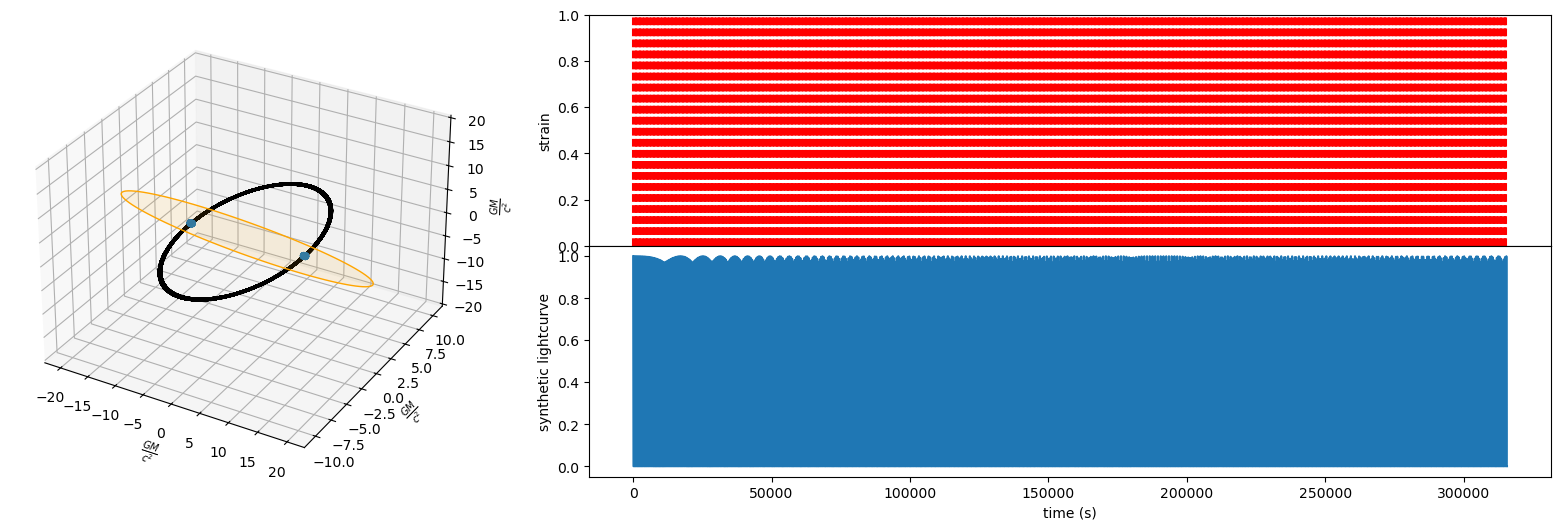

In [15]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 2], hspace=0, wspace=0.15)

# Top-right subplot (2D)
ax1 = fig.add_subplot(gs[0, 1])
plt.setp(ax1.get_xticklabels(), visible=False)
# Bottom-right subplot (2D), sharing the x-axis with ax1
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
# Left subplot spanning both rows, set up as a 3D projection
ax3 = fig.add_subplot(gs[:, 0], projection='3d')

# Plot on ax1 (top-right)
ax1.set_ylabel("strain")
for tt in intersections.T[0]:
    ax1.axvline(tt, color='red', linestyle='--')

# Plot on ax2 (bottom-right)
ax2.set_ylabel('synthetic lightcurve')
ax2.set_xlabel('time (s)')
ax2.plot(trajectory[0], lightcurve)

# Plot on ax3 (left, 3D)
plot_inclined_disk(ax3, disk_center0, radius=20, normal=disk_normal0, color='orange', alpha=0.1)
ax3.scatter(*intersections.T[1:])
ax3.plot3D(*trajectory[1:], 'black')
ax3.set_ylabel(r"$ \frac{GM}{c^2}$")
ax3.set_xlabel(r"$ \frac{GM}{c^2}$")
ax3.set_zlabel(r"$ \frac{GM}{c^2}$")

plt.subplots_adjust(hspace=0)
plt.savefig("EM_EMRI.pdf",bbox_inches='tight', pad_inches=0)
plt.show()